<link rel="stylesheet" type="text/css" href="styles.css">


<div class="title">
    <h1> Algorithme de détection automatique<br /> de faux billets </h1>

<link rel="stylesheet" type="text/css" href="styles.css">
    <p id=title-text> Contexte <p>

<p class=text-base>
L’Organisation nationale de lutte contre le faux-monnayage (ONCFM) est
une organisation publique ayant pour objectif de mettre en place des
méthodes d’identification des contrefaçons des billets en euros. </br>


Dans le cadre de cette lutte, ONCFM souhaitait mettre en place un algorithme qui
soit capable de différencier automatiquement les vrais des faux billets.</br>

Lorsqu’un billet arrive, une machine consigne l’ensemble
des caractéristiques géométriques des billets. Au fil de nos années de lutte, des différences de dimensions ont été observés entre les vrais et les faux billets. Ces différences sont difficilement visibles à l’oeil nu, cependant un algorithme devrait arriver à les différencier.
</p>


<div class=text2>
    <p class=title-text> Objectifs </p>
    <p> Construire un algorithme qui, à partir des caractéristiques géométriques d’un billet, soit capable de déterminer si ce dernier est un vrai ou un faux billet.</p>
</div>

<link rel="stylesheet" type="text/css" href="styles.css">
<div class=text2>
    <p class=title-text style=font-size: 180px> Modèle de données </br>
Dimensions géométriques </p>

● length : la longueur du billet (en mm)


● height_left : la hauteur du billet (mesurée sur le côté gauche, en mm)


● height_right : la hauteur du billet (mesurée sur le côté droit, en mm)


● margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm)


● margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;


● diagonal : la diagonale du billet (en mm).
</div>

## 1 - Bibliothèques et fonctions

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score,confusion_matrix, r2_score, mean_absolute_error, mean_squared_error, silhouette_score, f1_score, precision_score, roc_auc_score, recall_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import statsmodels.api as sm
from scipy import stats



from PCA_class import PCA_Analyse

In [2]:
# Masque les warnings
warnings.filterwarnings('ignore')

### Fonctions

In [3]:
def score_regression(y_test: np.array, y_pred: np.array) -> str:
    """Calcule les métrics d'un modèle de regression type linéaire

    Args:
        y_test (np.array): Valeurs réelles
        y_pred (np.array): Valeurs prédites

    Returns:
        str: Affiche les métrics : MAE, MSE, RMSE, R2
    """

    # Évaluation du modèle
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test, y_pred)

    # Afficher les résultats
    print(f"MAE: {MAE}")
    print(f"MSE: {MSE}")
    print(f"RMSE: {RMSE}")
    print(f"R^2: {R2}")



In [4]:
def distribution_résidus(y_test: pd.Series, y_pred: np.array) -> plt.subplots:
    """Affiche histogramme, KDE et scatter plot des résidus

    Args:
        y_test (np.array): Valeurs réelles
        y_pred (np.array): Valeurs prédites

    Returns:
        plt.subplots: Affiche histogramme, KDE et scatter plot des résidus

    """
    # Calcul des résidus issus de la régression
    residuals = y_test - y_pred

    # Nuage de points avec les résidus
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,7))

    # 1. Distribution des résidus
    sns.histplot(residuals, ax=ax1)
    ax1.set_title("Distribution des résidus", size=14, weight="bold")

    # 2. Graphique KDE
    sns.kdeplot(residuals, ax=ax2, fill=True)
    ax2.set_title("KDE des résidus", size=14, weight="bold")

    # 3. Nuage de points des résidus vs valeurs prédites
    ax3.scatter(y_test, residuals, alpha=0.5)
    ax3.axhline(0, color='red', linestyle='--')
    ax3.set_xlabel('Valeurs prédites', size=12)
    ax3.set_ylabel('Résidus', size=12)
    ax3.set_title('Graphique des résidus vs valeurs prédites' , size=14, weight="bold")

    fig.tight_layout()
    plt.show()

In [5]:
def display_metrics_model(y_true: np.array, y_pred: np.array):
    # Prédictions
    print(classification_report(y_true, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,include_values=True,
                                        display_labels=["faux billet","vrai billet"])
    plt.title("Matrice de confusion")
    plt.xlabel("Valeurs prédites")
    plt.ylabel("Valeurs réelles")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision : {precision_score(y_true, y_pred):.4f}")
    print(f"f1-score : {f1_score(y_true, y_pred):.4f}")
    print(f"ROC_AUC-score : {roc_auc_score(y_true, y_pred):.4f}")

    RocCurveDisplay.from_predictions(y_true, y_pred)
    plt.show()

In [6]:
def save_score_test(model, name_model, y_test, y_pred):
    hyperparameters = model.get_params()
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    scores = [acc, prec, recall, f1, auc, hyperparameters]
    columns = ["accuracy", "precision", "recall", "f1", "AUC_ROC", "hyperparmeters"]
    df = pd.DataFrame(data=[scores], columns=columns, index=[name_model]) 

    return df

In [7]:
def generate_sample_df(df: pd.DataFrame, n_files: int=5, sample_size: float=0.2):
    """Generate sample of dataframe with drop "is_genuine"

    Args:
        df (pd.DataFrame): dataframe to sampling
        n_files (int, optional): number files generated. Defaults to 5.
        sample_size (float, optional): size of the sample. Defaults to 0.2.
    """
    df_temp = df.drop("is_genuine",axis=1).copy()
    # Générer plusieurs fichiers CSV
    for i in range(n_files):
        # Échantillonner une partie du DataFrame

        df_sample = df_temp.sample(frac=sample_size, random_state=i)  # Changer `frac` à `n` si tu veux un nombre fixe de lignes

        # Sauvegarder l'échantillon dans un fichier CSV
        df_sample.to_csv(f'data/sample_billets_{i+1}.csv', index=False, sep=";")

        print(f'Fichier sample_{i+1}.csv généré avec {len(df_sample)} lignes')

## 2 - Import des données

In [8]:
# import du fichier
data = pd.read_csv("data/billets.csv", sep=";")

In [9]:
data.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [10]:
data.shape

(1500, 7)

In [11]:
# Copie des données pour pouvoir accéder au jeu initial tout au long du notebook
df = data.copy()

## 3 - Analyse exploratoire des données

### 3.1 - Statistiques descriptives

In [12]:
# Type de données et données manquantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [13]:
display(df.describe())

diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000

Distribution des différentes caractéristiques des billets

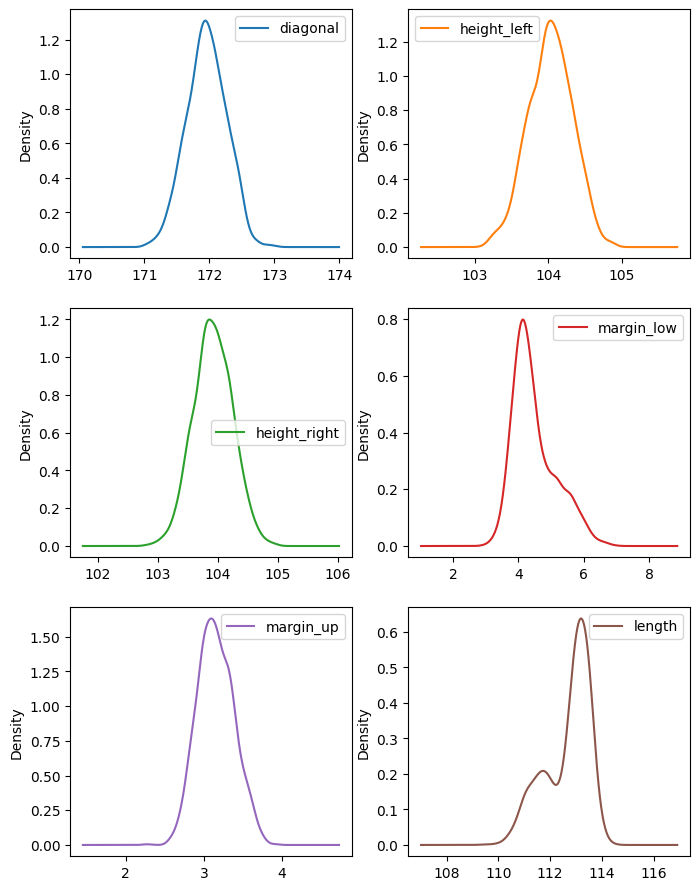

In [14]:
df.plot(subplots=True, kind="kde",
        sharex=False, sharey=False, figsize=(8,11),
        layout=(3,2))
plt.show()

Les KDE ci-dessus montrent des distributions ne semblant pas suivre une loi  Normale pour la longueur et la marge du bas des billets.

On observe même 2 pics pour la longueur des billets

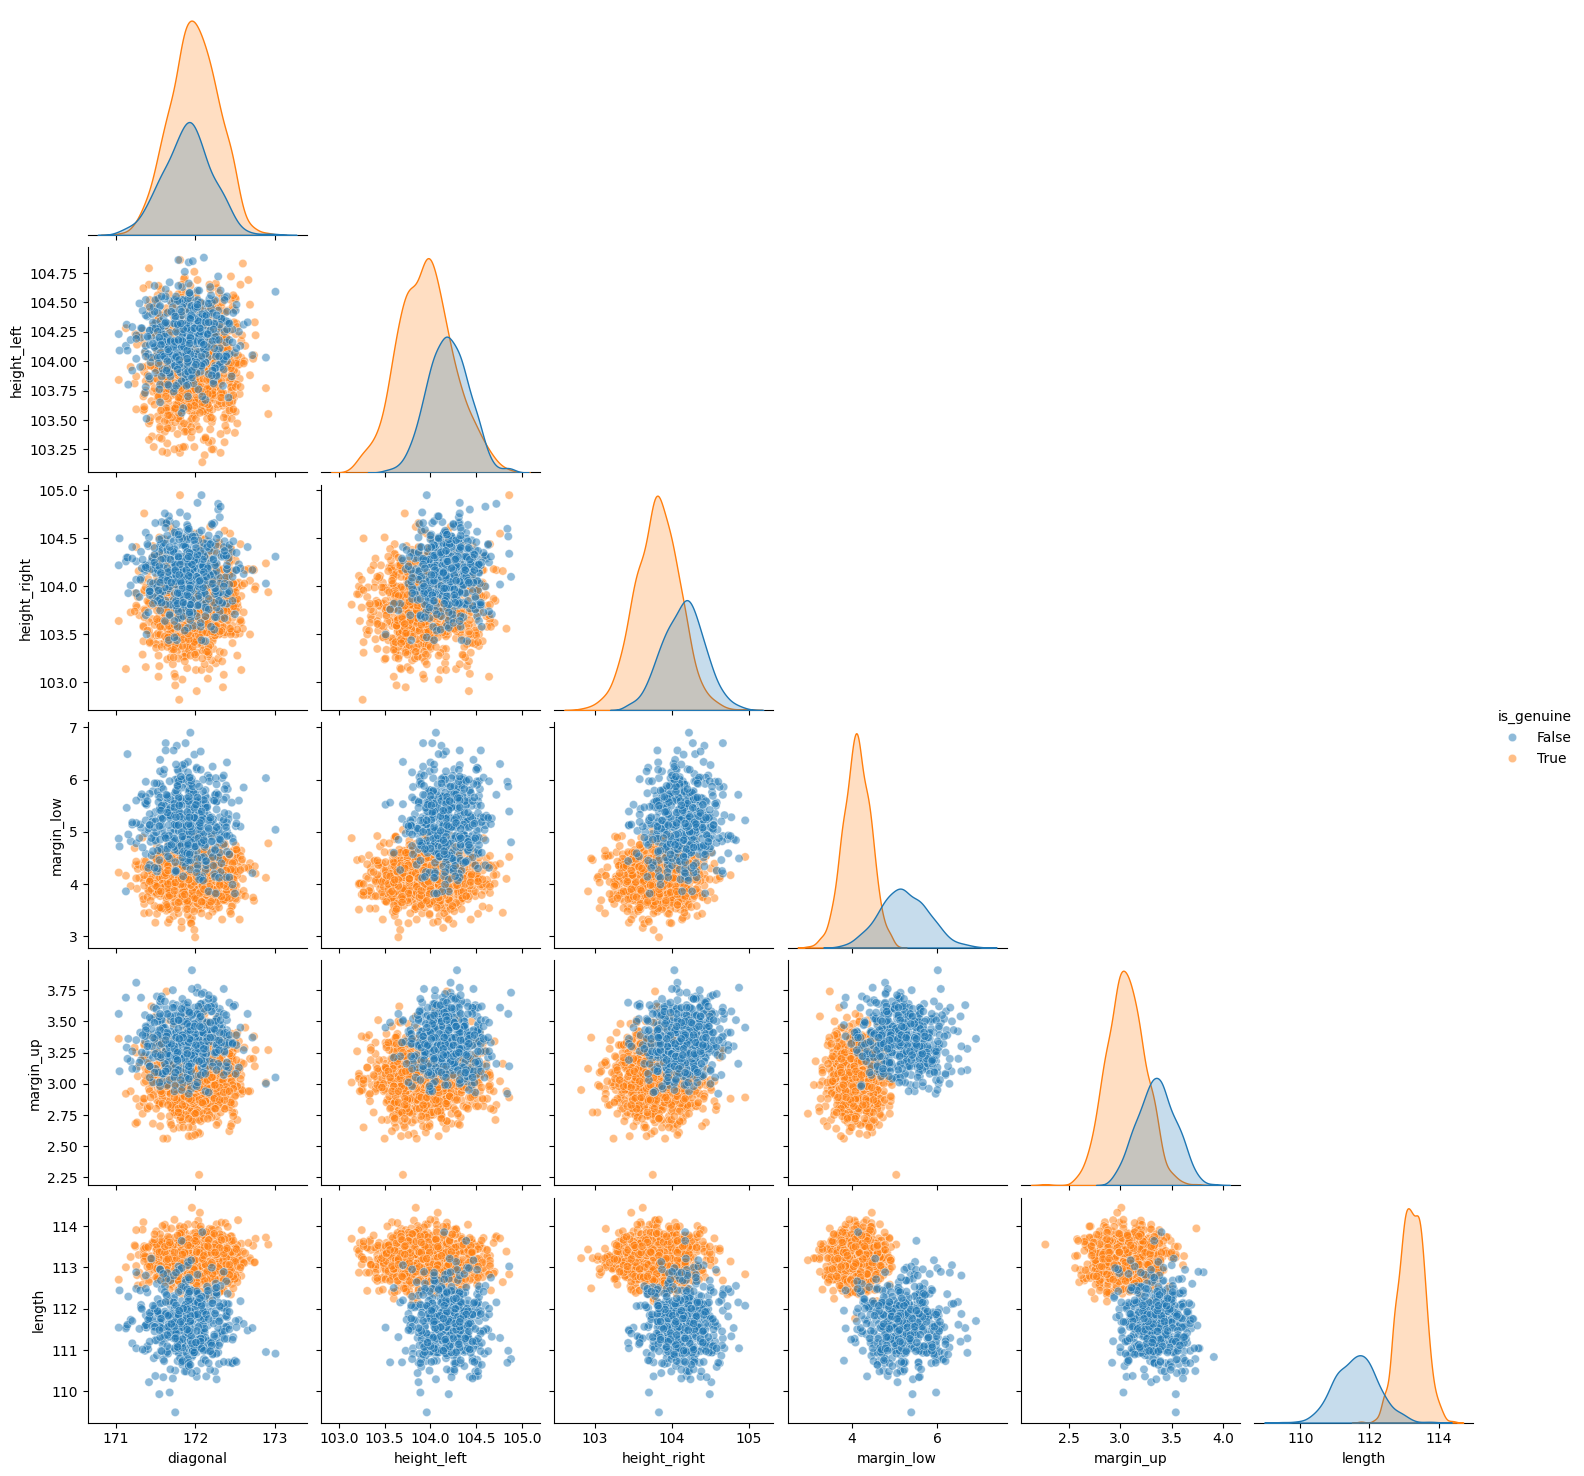

In [15]:
# Visualisation rapide des relations entre les varaibales et les vrais et faux billets
sns.pairplot(df, hue="is_genuine", corner=True, plot_kws={'alpha':0.5})
plt.show()

### 3.2 - Valeurs manquantes

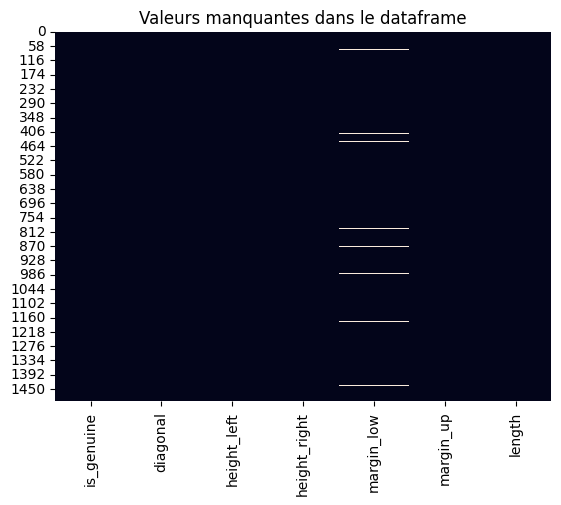

In [16]:
# Vérification des données manquantes
sns.heatmap(df.isnull(), cbar=False)
plt.title("Valeurs manquantes dans le dataframe")
plt.show()

In [17]:
df.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Pour la feature margin_low, 37 valeurs manquantes.
Comme conseillé par Marie, utilisation d'un régression linèaire pour compléter les valeurs manquantes

La colonne margin_low a 37 valeurs manquantes, afin de remplacer ces valeurs, test d'utilisation  d'une régression linéaire afin de compléter les valeurs manuantes de la colonne margin_low

### 3.3 - Corrélations entre variables

Avant de faire une régression, la colinéarité des variables doit être observée, afin de s"assurer que certaines ne soient pas trop corrélées entre elles, qui nécessiterait des traitements particuliers (suppression,... )

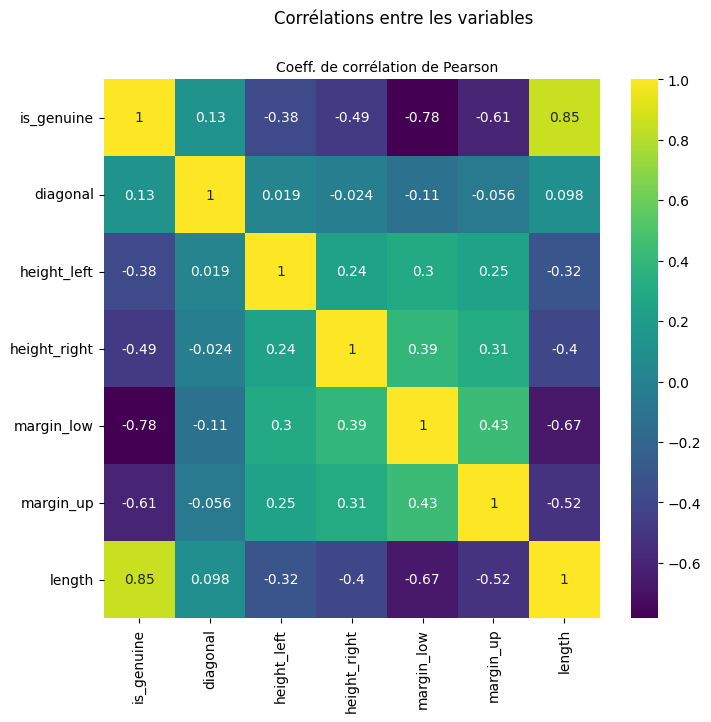

In [18]:
# Carte de chaleur avec les corrélations entre
# les différentes caractéristiqu,,es des billets
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(df.corr(method="pearson"), annot=True, cmap="viridis", ax=ax)
plt.suptitle("Corrélations entre les variables")
plt.title("                Coeff. de corrélation de Pearson", size=10)

plt.show()

Le coefficient de corrélation de Pearson ne fonctionne que pour des varaibles dont les variables suivent une loi normale. Dans notre dataset, les distributions de certaines variables ne suivent une loi normale.

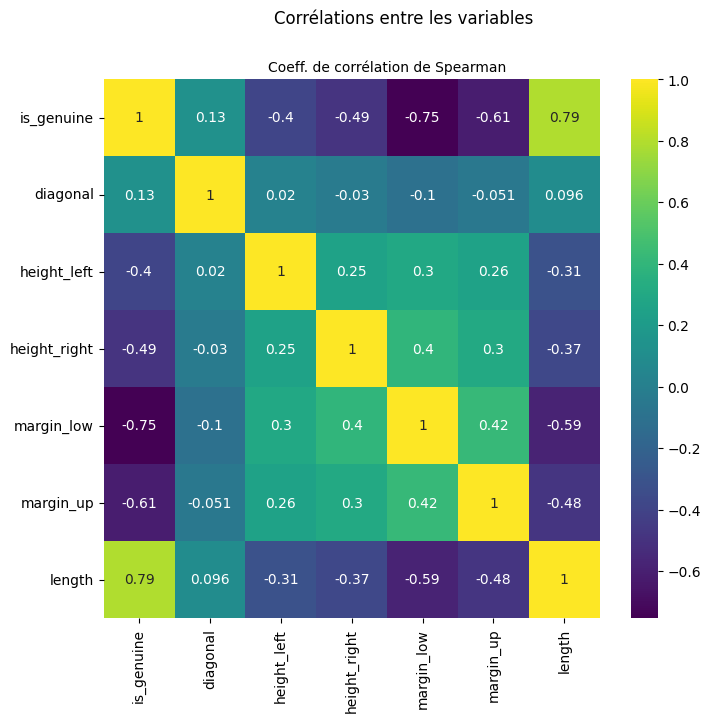

In [19]:
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(df.corr(method="spearman"), annot=True, cmap="viridis", ax=ax)
plt.suptitle("Corrélations entre les variables")
plt.title("                Coeff. de corrélation de Spearman", size=10)
plt.show()

Pour affiner, la compréhension de l"éventuelle colinéarité entre certaines variables, l"utilisation du coefficient de corrélation de Spearman permet de résoudre ce problème, car c"est une méthode non paramètrique fonctionnant sur le rang des valeurs et non sur leurs moyennes respectives

### Remplacement des valeurs manquantes

Pour limiter la perte d"informations du fait de l"absence de 37 valeurs pour la marge basse des billets, des régressions vont être réalisées pour tenter de compléter ces valeurs manquantes avec les prédictions issuent de ces régressions.

Nous utiliserons plusieurs méthode de régression : linéaire, ridge et lasso
Les derniers modèles permettent d'utiliser des paramètres de pénalités pour limiter l'influence de certaines variables.

##### Préparation des données

In [20]:
# Données sans valeur manquante (entrainement)
data_for_model = df[df["margin_low"].notnull()]
X = data_for_model.drop("margin_low",axis=1)
y = data_for_model["margin_low"]

# Données avec valeurs manquantes (ensemble pour prédiction)
data_to_predict = df[df["margin_low"].isnull()]
data_to_predict = data_to_predict.drop("margin_low", axis=1)
# print(f"Taille de train_df : {data_for_model.shape}")


In [21]:
scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# data_to_predict_scaled = scaler.transform(data_to_predict)

In [22]:
# test sans scale
X_scaled = X.copy()
data_to_predict_scaled = data_to_predict.copy()

In [23]:
# Transformation en entier de la valeur de vrais ou faux billets
X_scaled["is_genuine"] = X_scaled["is_genuine"].astype(int)
# X_scaled.drop("is_genuine", axis=1)

# Découpage du jeu de données
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=101)

#### 3.4.2 Régression linéaire multiple

In [24]:
# Régression linéaire (instaciation et entrainement)

reg_l = linear_model.LinearRegression()
reg_l.fit(X_train, y_train)

# Prediction sur le jeu de données test
y_pred = reg_l.predict(X_test)

Régression linéaire pour 'margin_low' 
Metrics :

MAE: 0.30353188157070227
MSE: 0.15498757674414326
RMSE: 0.39368461583371944
R^2: 0.6192234426538867


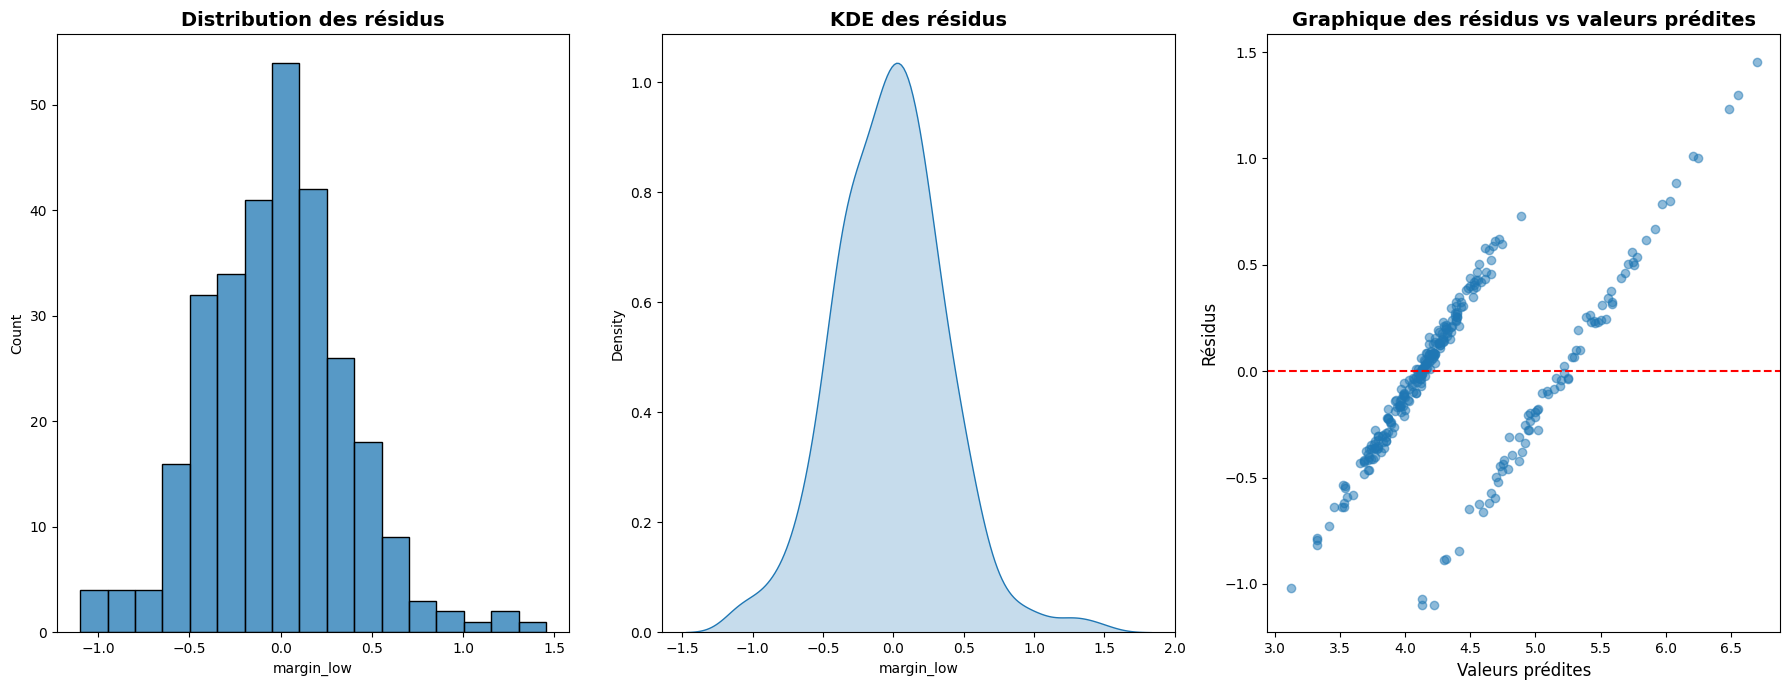

In [25]:
# Metrics du modele de régression linéaire
print("Régression linéaire pour 'margin_low' \nMetrics :\n")

score_regression(y_test=y_test, y_pred=y_pred)

# Evaluation de l'homoscedasticité des résidus

distribution_résidus(y_test=y_test, y_pred=y_pred)


#### 3.4.3 Régression Ridge

Meilleur alpha avec RidgeCV : 0.1
Régression RIDGE pour 'margin_low' 

hyperparamètres : alpha = 0.1

Metrics :

MAE: 0.3034609975969911
MSE: 0.15494651236081186
RMSE: 0.39363245846958794
R^2: 0.6193243304465921


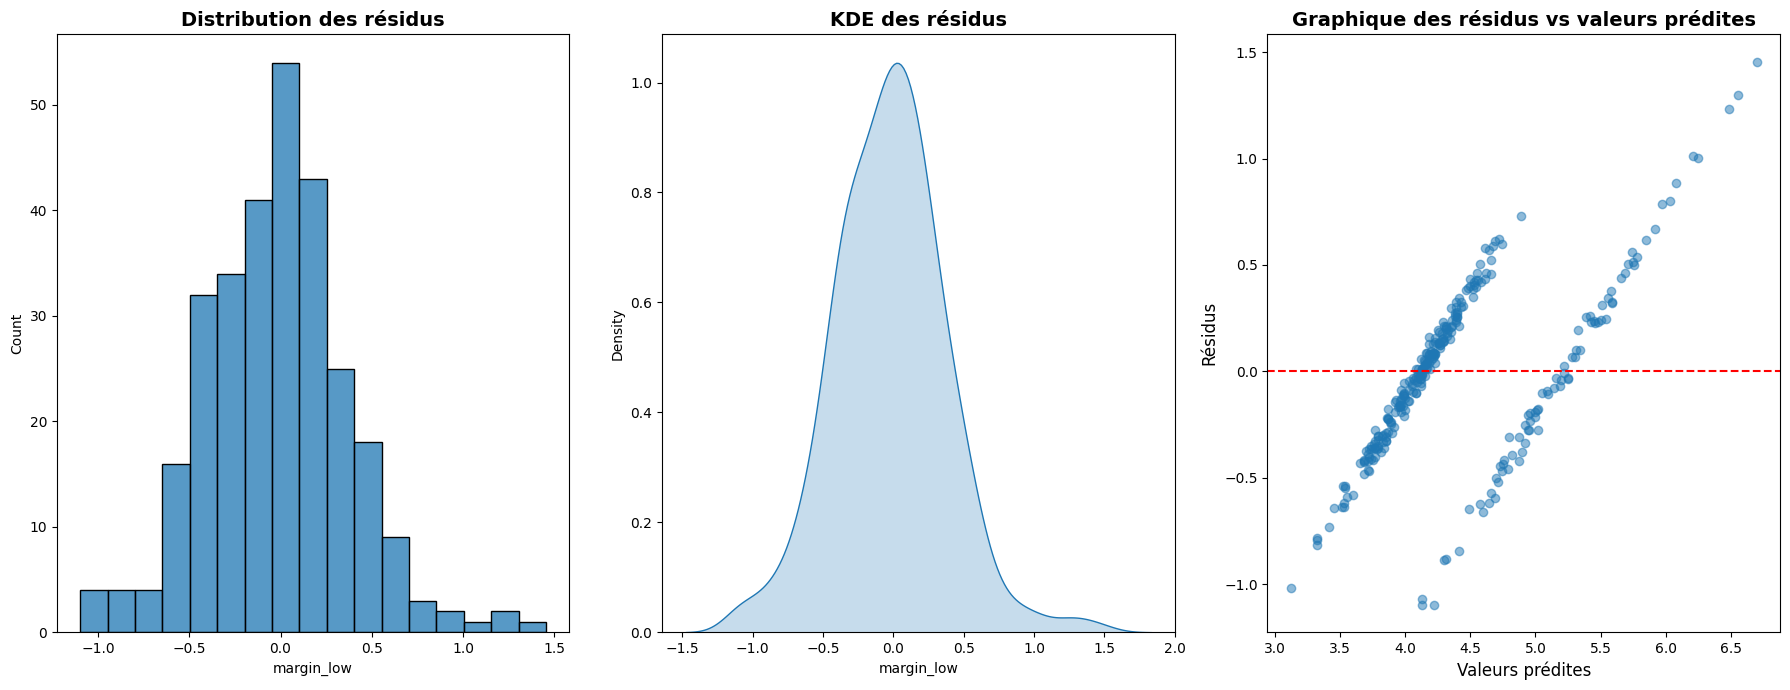

In [26]:
# Tester plusieurs valeurs d'alpha avec RidgeCV
ridge_cv = linear_model.RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5)
ridge_cv.fit(X_train, y_train)
 
# Meilleur alpha trouvé
print(f"Meilleur alpha avec RidgeCV : {ridge_cv.alpha_}")



# Prédictions avec le modèle optimisé
y_pred = ridge_cv.predict(X_test)

# Metrics du modele
print("Régression RIDGE pour 'margin_low' \n")
print(f"hyperparamètres : alpha = {ridge_cv.alpha_}\n")
print("Metrics :\n")

score_regression(y_test=y_test, y_pred=y_pred)

# Evaluation de l'homoscedasticité des résidus
distribution_résidus(y_test=y_test, y_pred=y_pred)

#### 3.4.4 Régression Lasso

EXPLICATIONS LASSO

Régression LASSO pour 'margin_low' 

hyperparamètres : alpha = 0.007258115514676281

Metrics :

MAE: 0.3026073714283382
MSE: 0.15560761122107472
RMSE: 0.3944713059540259
R^2: 0.617700129634085


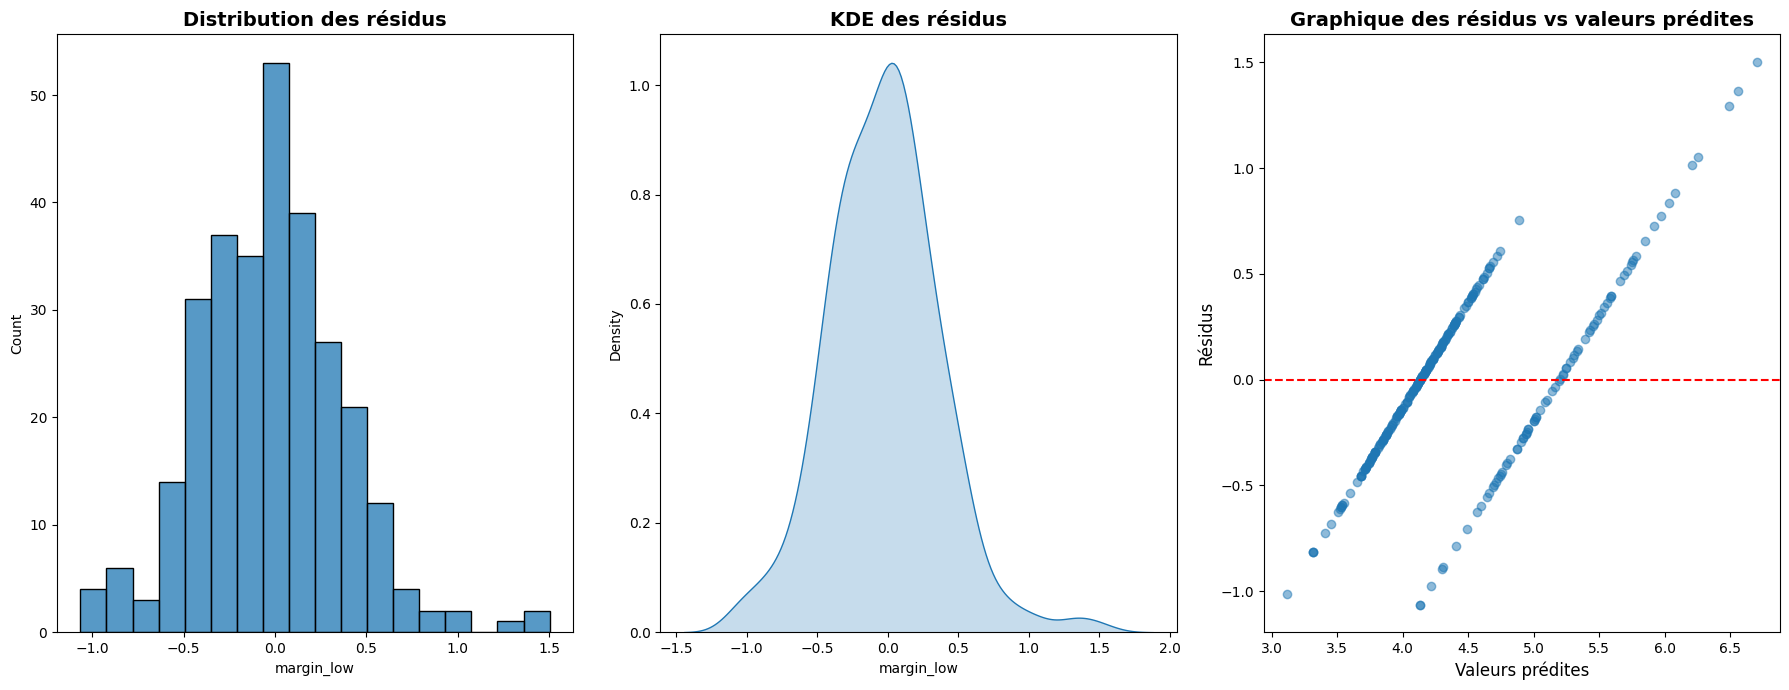

In [27]:
reg_lasso = linear_model.LassoCV(alphas=None, cv=5, max_iter=10000, random_state=42)
reg_lasso.fit(X_train, y_train)

# Prediction sur le jeu de données test
y_pred = reg_lasso.predict(X_test)

# Metrics du modele
print("Régression LASSO pour 'margin_low' \n")
print(f"hyperparamètres : alpha = {reg_lasso.alpha_}\n")
print("Metrics :\n")

score_regression(y_test=y_test, y_pred=y_pred)

# Evaluation de l'homoscedasticité des résidus
distribution_résidus(y_test=y_test, y_pred=y_pred)

#### 3.4.5 Comparaison des modèles de régressions


<link rel="stylesheet" type="text/css" href="styles.css">

<span class=text-base> 
Les régressions réalisées sur le jeu de données ne performent pas bien. Le R² plafonne à 0.6, ce qui est relativement faible.

L'analyse de la distribution des résidus des différentes régressions réalisées confirme la non-pertinence de ces modèles car elle présente une hétéroscédasticité des résidus.

Le test de Barlett aurait pu être utilisé pour tester l'hypothèse nulle : les variances des résidus ne sont pas homogènes. Mais les mauvais résultats précéddents suffisent à exclure l'utilisation d'une régression pour compléter les valeurs manquantes dans la colonne margin_low.

</span>

##### Corrélation entre longueur et marge du bas des billets

              length  margin_low
length      1.000000   -0.666753
margin_low -0.666753    1.000000


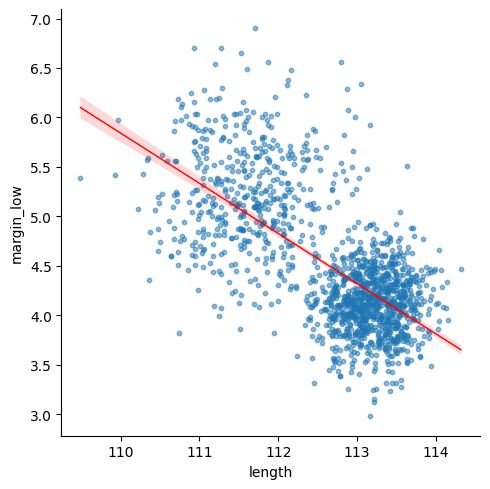

In [28]:
print(df[["length", "margin_low"]].corr())

sns.lmplot(df, x="length", y="margin_low",seed=42,
            scatter_kws={'alpha':0.5, "s":10},
            line_kws={"color":"red", "linewidth": 1})
plt.show()


<link rel="stylesheet" type="text/css" href="styles.css">

<span class=text-base> 


Seules 37 données sont manquantes sur  le dataset soit 2,5% des données. Par précaution, ces lignes de données seront supprimées du dataset pour la classification.</span>

#### Suppression des valeurs manquantes

In [29]:
# Suppression des valeurs manquantes
df.dropna(inplace=True)
print(f"Dimensions de df : {df.shape}")

# Vérfication des valeurs manquantes
print("Valeurs manquantes :")
print(df.isnull().sum())

Dimensions de df : (1463, 7)
Valeurs manquantes :
is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


### 3.5 - Analyse exploratoire des données (suite)

In [30]:
df.describe()

diagonal  height_left  height_right   margin_low    margin_up  \
count  1463.000000  1463.000000   1463.000000  1463.000000  1463.000000   
mean    171.959193   104.031333    103.921476     4.485967     3.153083   
std       0.305457     0.299605      0.324181     0.663813     0.231466   
min     171.040000   103.140000    102.910000     2.980000     2.270000   
25%     171.750000   103.825000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.315000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

            length  
count  1463.000000  
mean    112.674757  
std       0.873222  
min     109.490000  
25%     112.020000  
50%     112.960000  
75%     113.340000  
max     114.320000

Les données des caractéristiques semblent être assez cohérentes avec peu de variations entre les différentes caractéristiques des billets, notamment avec des écarts-type relativement faibles

#### Répartition vrai et faux billets dans le dataset

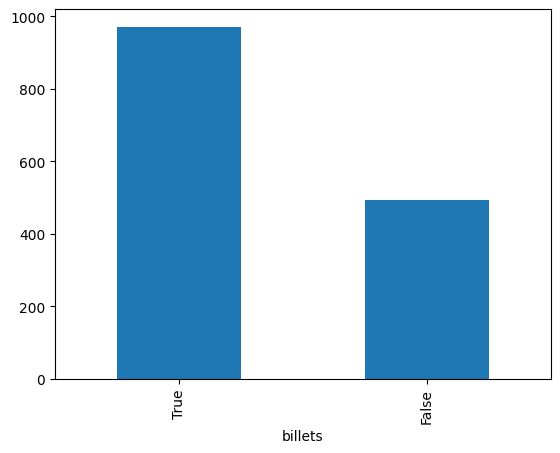

Probabilité d'avoir un vrai billets dans le dataset :  0.66
Probabilité d'avoir un vrai billets dans le dataset :  0.34


In [31]:
# Barplot avec classes de la valeur cible
df['is_genuine'].value_counts().plot(kind="bar", xlabel="billets")
plt.show()

# Calcul de la probabilité de ces 2 classes 

P_True = df[df['is_genuine'] == True].shape[0] / df.shape[0]
P_False = df[df['is_genuine'] == False].shape[0] / df.shape[0]
print(f"Probabilité d'avoir un vrai billets dans le dataset : {P_True: .2f}")
print(f"Probabilité d'avoir un vrai billets dans le dataset : {P_False: .2f}")

Nous observons un certain déséquilibre dans les classes : la classe majoritaire est vrai billet.
Cela équivaut à 1 chance sur 3 de prédire un vrai billets. L'objectif étant de détecter les faux billets, il sera necessaire d'envisager une stratégie pour rééquilibrer les 2 classes.

#### Distribution (boxplot) des variables

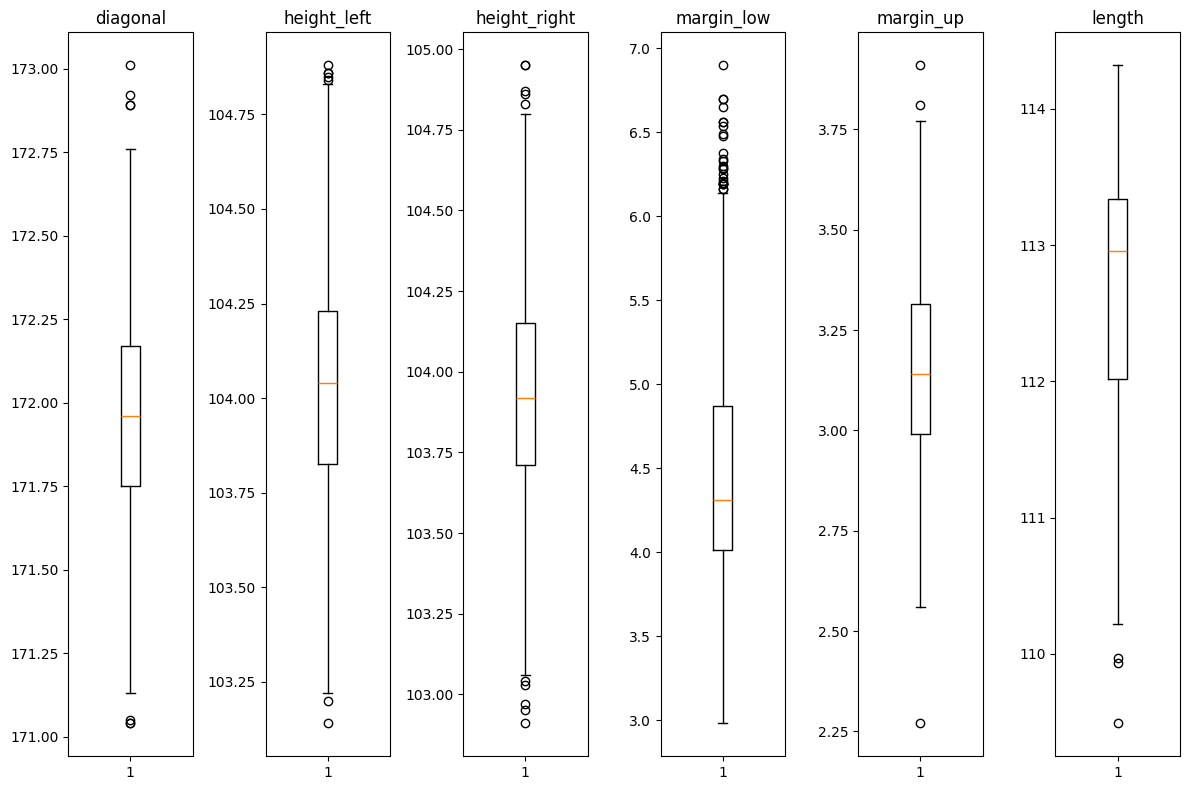

In [32]:
# boxplot avec distributions des variables
fig, ax = plt.subplots(1,6, figsize=(12,8))
for i, col in enumerate(df.select_dtypes(include='number').columns.values):
    ax[i].boxplot(df[col])
    ax[i].set_title(col)
plt.tight_layout()

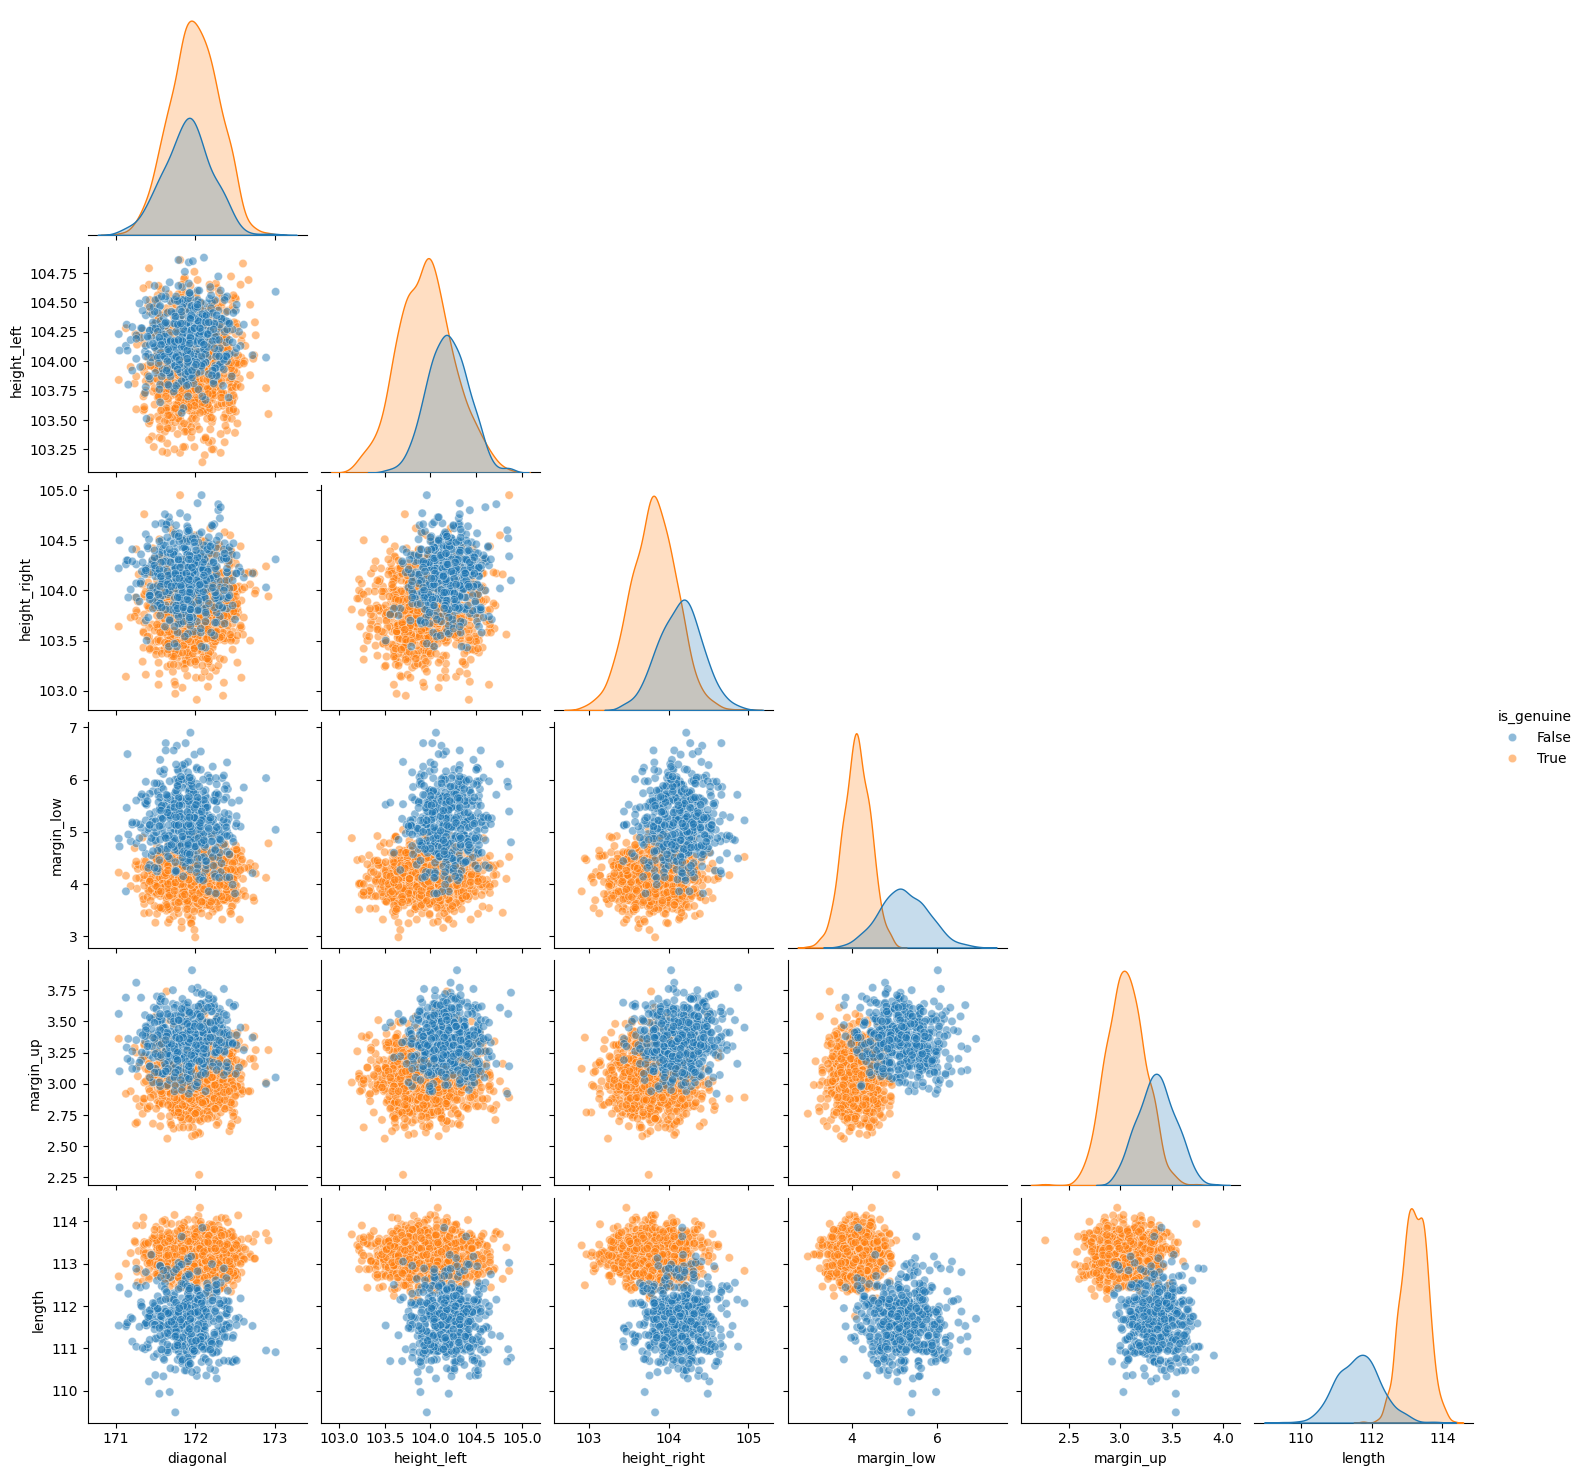

In [33]:
# Visualisation rapide des relations entre les varaibales et les vrais et faux billets
sns.pairplot(df, hue="is_genuine", corner=True, plot_kws={'alpha':0.5})
plt.show()

### 3.6 - Tests de normalité des distribution des carctéristiques des billets

Afin de s'assurer d'utiliser les bonnes approches, le test de Shapiro-Wilk sera utilisé.

Hypothéses : 

- H0 : Las distribution est normale
- H1 : La distribution n'est pas normale

In [34]:
# Test de Shapiro-Wilk

def test_shapiro(df: pd.DataFrame) -> str:
    """Vérifie la normalité des colonnes d'un dataframe avec des floats 

    Args:
        df (pd.DataFrame): data

    Returns:
        str: Affiche le résultats du test avec rejet ou non de H0 (les données suivent une distribution normale)
    """

    for col in df.select_dtypes(float):
        stat, p_value = stats.shapiro(df[col])
        # Interprétation
        alpha = 0.05
        if p_value > alpha:
            print(f"{col} : Les données suivent une distribution normale (on ne rejette pas H0)")
        else:
            print(f"{col} : Les données ne suivent pas une distribution normale (on rejette H0)")


In [35]:
test_shapiro(df)

diagonal : Les données suivent une distribution normale (on ne rejette pas H0)
height_left : Les données suivent une distribution normale (on ne rejette pas H0)
height_right : Les données suivent une distribution normale (on ne rejette pas H0)
margin_low : Les données ne suivent pas une distribution normale (on rejette H0)
margin_up : Les données ne suivent pas une distribution normale (on rejette H0)
length : Les données ne suivent pas une distribution normale (on rejette H0)


Seules les données relatives à la diagonale, la hauteur gauche et la hauteur droite des billets suivent une loi normale

### 3.7 - Evaluation et gestion des outliers

Pour vérifier la présence d'outlier dans le jeu de données, deux méthodes seront utilisées pour détecter ces éventuelles valeurs aberrantes : z_score et écart interquartile.

#### 3.7.1 - Z-score

In [36]:
df.describe()[2:]

diagonal  height_left  height_right  margin_low  margin_up      length
std    0.305457     0.299605      0.324181    0.663813   0.231466    0.873222
min  171.040000   103.140000    102.910000    2.980000   2.270000  109.490000
25%  171.750000   103.825000    103.710000    4.015000   2.990000  112.020000
50%  171.960000   104.040000    103.920000    4.310000   3.140000  112.960000
75%  172.170000   104.230000    104.150000    4.870000   3.315000  113.340000
max  173.010000   104.880000    104.950000    6.900000   3.910000  114.320000

In [37]:
# Calcul du Z_score
print("Nombre d'outliers avec le z-score")
index_outliers_zscore = []
for col in df.select_dtypes(float):
    z_scores = stats.zscore(df[col])
    index_outliers = z_scores[z_scores > 3].index
    print(f"{col} : {(z_scores>3).sum()}")
    for i in range(index_outliers.shape[0]):
        if ((z_scores>3).sum())>0:
            index_outliers_zscore.append(index_outliers[i])

    display(df[df.index.isin(index_outliers)])
print("Liste des indexs uniques", np.unique(index_outliers_zscore))

print(f"Nombre d'outliers avec z-score : {len(np.unique(index_outliers_zscore))}")

Nombre d'outliers avec le z-score
diagonal : 4


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
828         True    172.92       103.55        103.94        4.78       3.27   
842         True    172.89       103.77        104.24        4.12       3.01   
1022       False    172.89       104.03        104.03        6.03       3.00   
1277       False    173.01       104.59        104.31        5.04       3.05   

      length  
828   113.55  
842   113.72  
1022  110.95  
1277  110.91

height_left : 0


Empty DataFrame
Columns: [is_genuine, diagonal, height_left, height_right, margin_low, margin_up, length]
Index: []

height_right : 2


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1484       False    172.08       103.96        104.95        5.22       3.45   

      length  
0     112.83  
1484  112.07

margin_low : 9


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
1027       False    171.63       104.02        104.66        6.70       3.28   
1041       False    171.77       104.12        104.42        6.65       3.63   
1110       False    171.73       104.32        104.07        6.56       3.30   
1124       False    171.88       103.92        104.27        6.70       3.11   
1169       False    171.99       104.14        104.15        6.48       3.42   
1254       False    171.15       104.09        104.30        6.49       3.20   
1290       False    171.94       104.06        104.22        6.90       3.36   
1441       False    171.63       104.55        103.81        6.56       3.10   
1464       False    172.07       104.17        104.37        6.54       3.54   

      length  
1027  111.28  
1041  111.53  
1110  112.80  
1124  110.93  
1169  112.16  
1254  111.61  
1290  111.70  
1441  111.87  
1464  111.20

margin_up : 1


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
1029       False    171.96       104.29        104.03        6.01       3.91   

      length  
1029  110.83

length : 0


Empty DataFrame
Columns: [is_genuine, diagonal, height_left, height_right, margin_low, margin_up, length]
Index: []

Liste des indexs uniques [   0  828  842 1022 1027 1029 1041 1110 1124 1169 1254 1277 1290 1441
 1464 1484]
Nombre d'outliers avec z-score : 16


In [38]:
# Vérification de la répartition des ouliers dans les classes vrais et faux billets
df[df.index.isin(index_outliers_zscore)]["is_genuine"].value_counts()

is_genuine
False    13
True      3
Name: count, dtype: int64

In [39]:
df.is_genuine.value_counts()

is_genuine
True     971
False    492
Name: count, dtype: int64

Ces 16 outliers représentent 1,1 % du dataset, mais 2.7 % des faux billets

81 % des outliers sont des faux billets. La suppression des outliers risque d'entrainer de la perte d'information pour déterminer avec précision les faux billets.

#### 3.7.1 - Ecarts interquartiles

In [40]:
# Calcul de l'intervalle interquartile
print("Nombre d'outliers avec l'écart interquartile")
index_outliers_IQR = []
for col in df.select_dtypes(float):
    # Calcul des quartiles Q1 et Q3
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)

    # Calcul de l'IQR
    IQR = Q3 - Q1

    # Détection des outliers
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR

    outliers_IQR = df[(df[col] < limite_inf) | (df[col] > limite_sup)].index
    print(f"{col} : {len(outliers_IQR)}")
    for i in range(outliers_IQR.shape[0]):
        index_outliers_IQR.append(outliers_IQR[i])

    display(df[df.index.isin(outliers_IQR)])
print("Liste des indexs uniques", np.unique(index_outliers_IQR))
nb_outliers_IQR = len(np.unique(index_outliers_IQR))
print(f"Nombre d'outliers avec z-score : {nb_outliers_IQR}")

Nombre d'outliers avec l'écart interquartile
diagonal : 7


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
729         True    171.04       103.84        103.64        4.22       3.36   
828         True    172.92       103.55        103.94        4.78       3.27   
842         True    172.89       103.77        104.24        4.12       3.01   
1022       False    172.89       104.03        104.03        6.03       3.00   
1142       False    171.04       104.23        104.22        4.87       3.56   
1277       False    173.01       104.59        104.31        5.04       3.05   
1388       False    171.05       104.09        104.50        4.72       3.10   

      length  
729   112.70  
828   113.55  
842   113.72  
1022  110.95  
1142  111.54  
1277  110.91  
1388  112.44

height_left : 7


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
224         True    172.12       103.20        103.92        4.46       3.26   
292         True    172.09       103.14        103.81        4.88       3.01   
1090       False    172.11       104.88        104.10        4.80       3.73   
1150       False    171.79       104.86        104.34        5.39       3.14   
1310       False    171.92       104.84        104.60        5.96       2.92   
1382       False    171.97       104.85        104.52        5.87       3.56   

      length  
0     112.83  
224   113.44  
292   113.69  
1090  110.78  
1150  113.02  
1310  110.69  
1382  110.98

height_right : 10


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
77          True    171.84       104.09        103.03        4.11       2.77   
176         True    171.75       103.63        102.97        4.46       2.77   
193         True    172.35       103.73        102.95        4.49       3.37   
522         True    172.02       104.42        102.91        3.86       3.12   
761         True    172.16       103.93        103.04        4.14       2.99   
1199       False    172.03       104.32        104.87        4.49       3.77   
1321       False    172.29       104.72        104.86        5.71       3.16   
1331       False    172.32       104.60        104.83        4.84       3.51   
1484       False    172.08       103.96        104.95        5.22       3.45   

      length  
0     112.83  
77    113.18  
176   113.22  
193   112.49  
522   113.43  
761   113.26  
1199  111.04  
1321  112.15  
1331  112.55  
1484  112.07

margin_low : 24


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
1023       False    172.02       104.26        104.20        6.20       3.58   
1027       False    171.63       104.02        104.66        6.70       3.28   
1031       False    172.40       104.00        103.82        6.33       3.10   
1041       False    171.77       104.12        104.42        6.65       3.63   
1053       False    171.85       104.52        104.05        6.21       3.43   
1075       False    172.02       104.51        103.69        6.23       3.39   
1092       False    171.87       104.76        104.02        6.30       3.61   
1110       False    171.73       104.32        104.07        6.56       3.30   
1124       False    171.88       103.92        104.27        6.70       3.11   
1133       False    171.79       103.99        103.67        6.16       3.52   
1134       False    171.91       103.70        104.41        6.34       3.50   
1169       False    171.99       104.14        104.15        6.48       3.42   
1254       False    171.15       104.09        104.30        6.49       3.20   
1290       False    171.94       104.06        104.22        6.90       3.36   
1322       False    172.07       104.50        104.23        6.19       3.07   
1345       False    171.56       104.17        103.87        6.16       3.38   
1348       False    171.84       104.32        104.50        6.28       3.00   
1353       False    171.61       104.04        104.06        6.19       3.08   
1420       False    171.56       104.47        104.04        6.38       3.43   
1426       False    172.22       103.92        104.03        6.25       3.14   
1441       False    171.63       104.55        103.81        6.56       3.10   
1459       False    171.78       104.31        103.82        6.19       3.25   
1464       False    172.07       104.17        104.37        6.54       3.54   
1473       False    171.76       104.04        104.12        6.29       3.20   

      length  
1023  111.25  
1027  111.28  
1031  112.11  
1041  111.53  
1053  111.96  
1075  112.35  
1092  111.29  
1110  112.80  
1124  110.93  
1133  110.93  
1134  113.05  
1169  112.16  
1254  111.61  
1290  111.70  
1322  111.21  
1345  111.55  
1348  111.06  
1353  110.73  
1420  112.12  
1426  110.89  
1441  111.87  
1459  111.14  
1464  111.20  
1473  112.87

margin_up : 3


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
664         True    172.05       103.70        103.75        5.04       2.27   
1029       False    171.96       104.29        104.03        6.01       3.91   
1270       False    171.26       104.22        104.07        4.78       3.81   

      length  
664   113.55  
1029  110.83  
1270  112.88

length : 3


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
1082       False    171.75       103.96        103.83        5.39       3.54   
1355       False    171.68       103.89        103.70        5.97       3.03   
1453       False    171.55       104.20        104.49        5.42       3.54   

      length  
1082  109.49  
1355  109.97  
1453  109.93

Liste des indexs uniques [   0   77  176  193  224  292  522  664  729  761  828  842 1022 1023
 1027 1029 1031 1041 1053 1075 1082 1090 1092 1110 1124 1133 1134 1142
 1150 1169 1199 1254 1270 1277 1290 1310 1321 1322 1331 1345 1348 1353
 1355 1382 1388 1420 1426 1441 1453 1459 1464 1473 1484]
Nombre d'outliers avec z-score : 53


In [41]:
# Vérification de la répartition des ouliers dans les classes vrais et faux billets
a = df[df.index.isin(index_outliers_IQR)]["is_genuine"].value_counts()
a

is_genuine
False    41
True     12
Name: count, dtype: int64

In [42]:
print(f" Ces {nb_outliers_IQR} outliers représentent{nb_outliers_IQR/df.shape[0]: .2%} du dataset",
      f"et{nb_outliers_IQR/df[df["is_genuine"]==1].shape[0]: .2%} des faux billets")

print(f"{a[a.index == False].values[0] / nb_outliers_IQR: .2%} des outliers sont des faux billets")

 Ces 53 outliers représentent 3.62% du dataset et 5.46% des faux billets
 77.36% des outliers sont des faux billets


<div class="alert alert-warning">
<b>Pas de suppression des outliers car elle risque d'entrainer de la perte d'information pour déterminer avec précision les faux billets.</b>
</div>

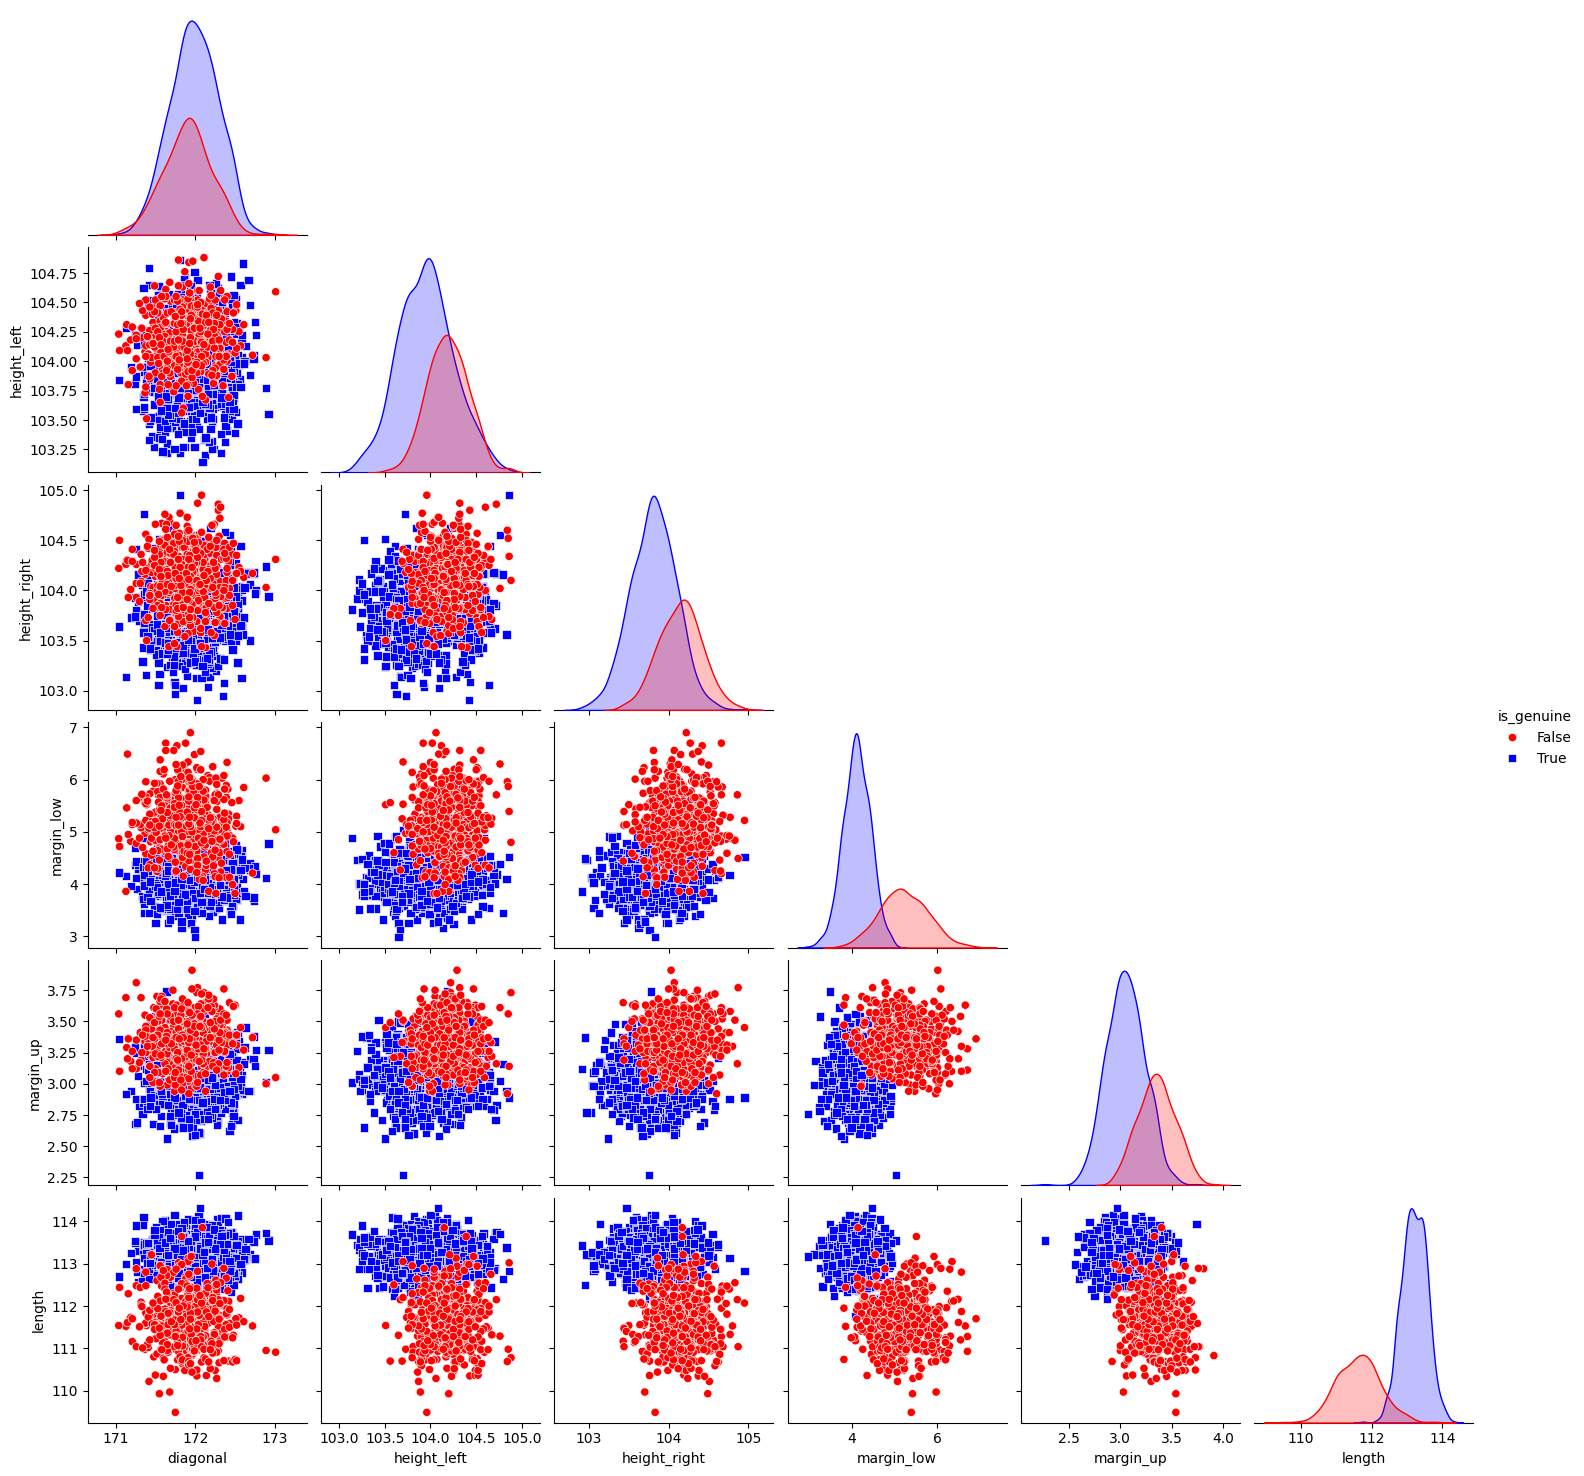

In [43]:
sns.pairplot(df, vars=df.select_dtypes(float).columns.values,
             hue="is_genuine",
             markers=["o", "s"],
             palette = {0: 'red', 1: 'blue'},
             corner=True)
plt.show()

## 4 - Algorithmes pour détection des faux billets

### 4.1 - Préparation des données

In [44]:
# Definition des variables X, y, n, p

X = df.drop(columns="is_genuine").copy()
y = df["is_genuine"].copy()

n = X.shape[0]
features = X.columns
random_state = 101

print(f"dimensions de X : {X.shape}")
print(f"dimensions de y : {y.shape}")
print(f"features : {features.values}")
print(f"Valeurs cibles : 'is_genuine'")

dimensions de X : (1463, 6)
dimensions de y : (1463,)
features : ['diagonal' 'height_left' 'height_right' 'margin_low' 'margin_up' 'length']
Valeurs cibles : 'is_genuine'


### 4.2 - Analyse en Composantes Principales

L'Analyse en Composantes Principales (ACP) permet de réduire la dimensionalité du jeu de données.

Elle permettra de mieux comprendre le poids des différentes variables et surtout faciliter l'affichage des informations 

In [45]:
pca = PCA_Analyse()
pca.instance_fit_PCA(df=df.drop("is_genuine", axis=1))

Description de X : 
n (observations): 1463 
p (variables): 6
Les données ont été mises à l'echelle avec StandardScaler()
Paramètre de la PCA :
{'copy': True, 'iterated_power': 'auto', 'n_components': None, 'n_oversamples': 10, 'power_iteration_normalizer': 'auto', 'random_state': None, 'svd_solver': 'full', 'tol': 0.0, 'whiten': False}
L'entrainement des données avec l'ACP a été réalisée
----------------------------------------------------------------------------------------------------
Taille de : (1463, 6)
Nombre de composantes : 6


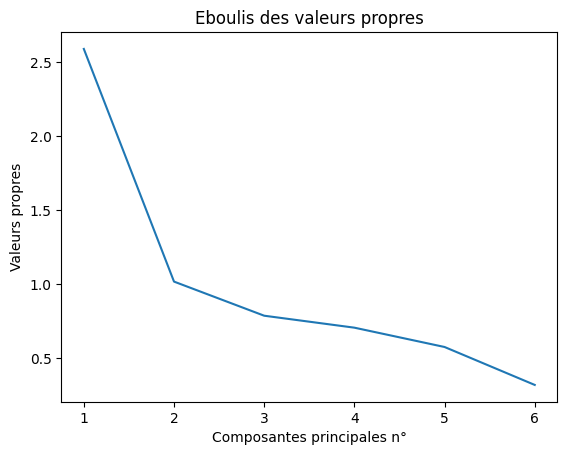

In [46]:
pca.scree_plot()

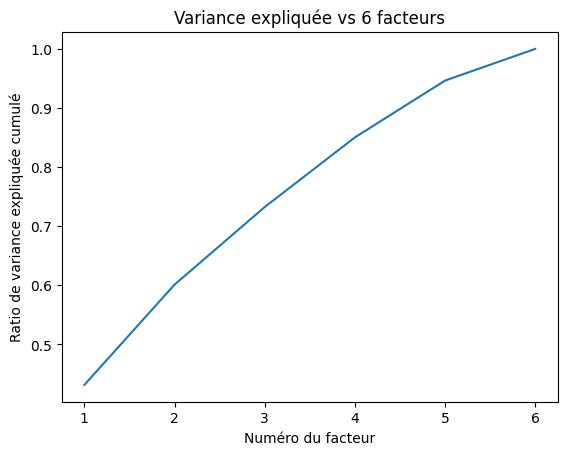

In [47]:
pca.explained_variance_vs_factors_plot()

In [48]:
pca.get_explained_variance_()


Proportion de variance expliquée :
 [0.43123527 0.16970651 0.13136423 0.11792169 0.0962036  0.0535687 ]


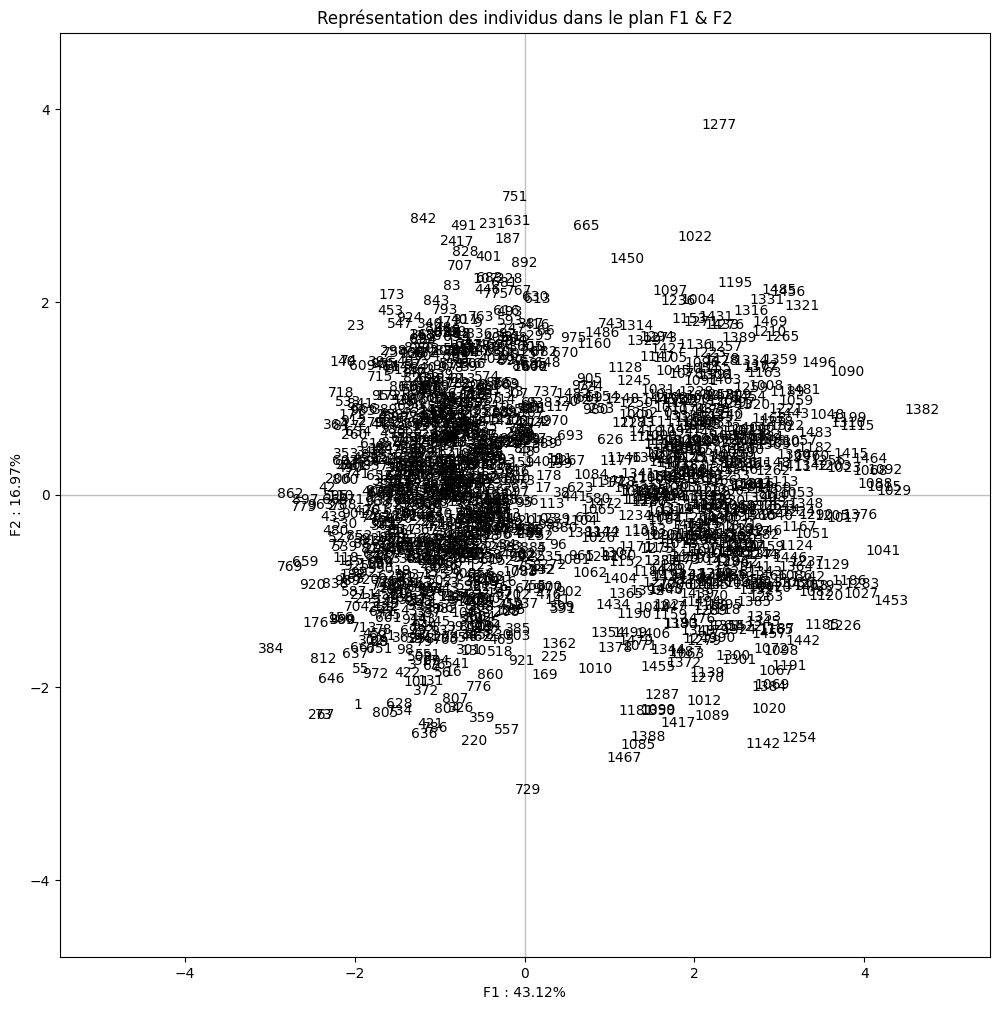

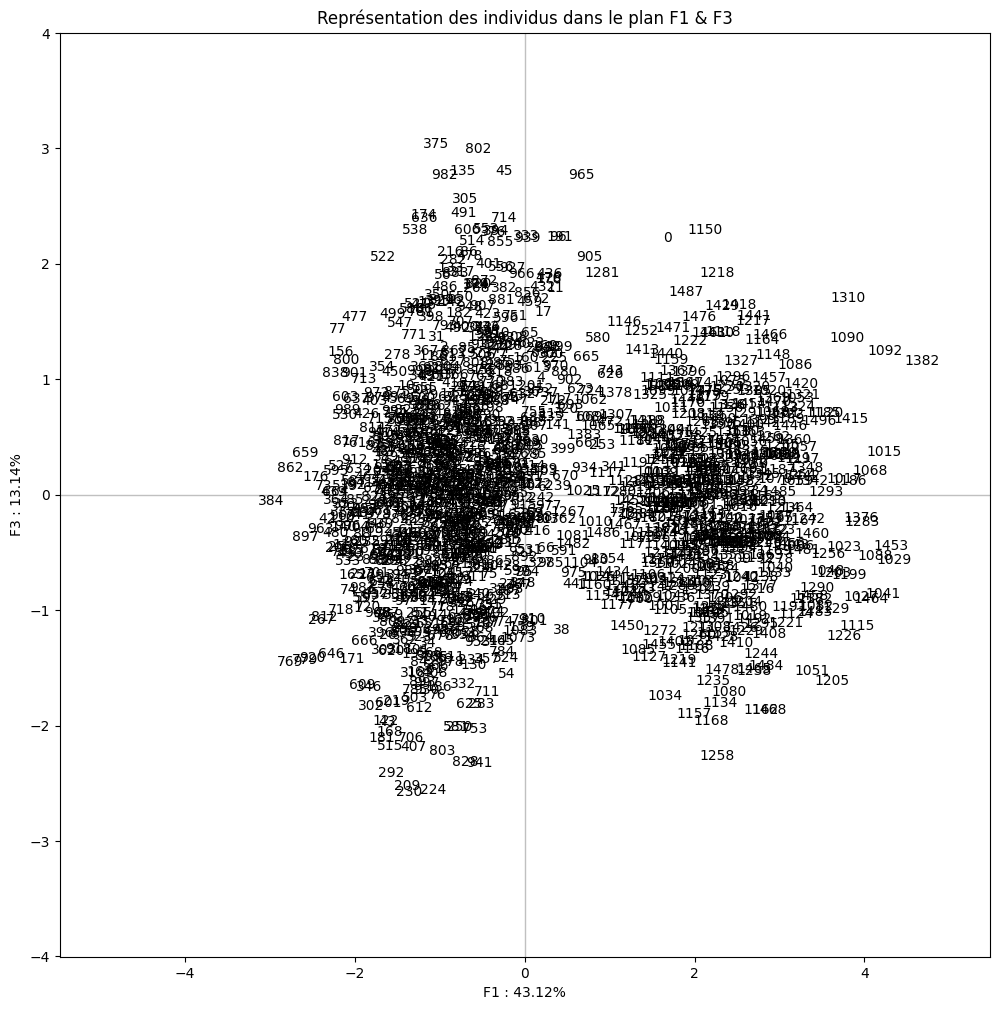

In [49]:
pca.individuals_plot(plan_x=1, plan_y=2)
pca.individuals_plot(plan_x=1, plan_y=3)

In [50]:
pca.acp.explained_variance_ratio_

array([0.43123527, 0.16970651, 0.13136423, 0.11792169, 0.0962036 ,
       0.0535687 ])

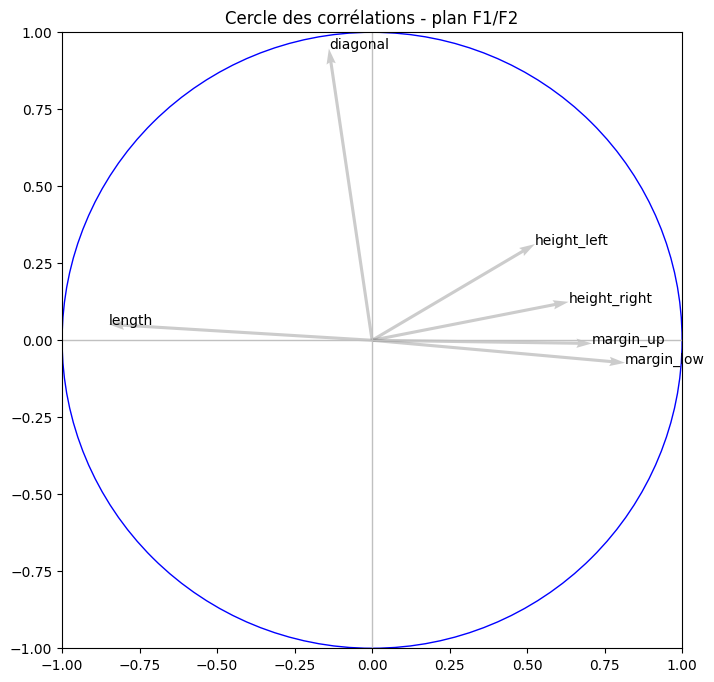

In [51]:
pca.correlation_circle_plot(1,2)


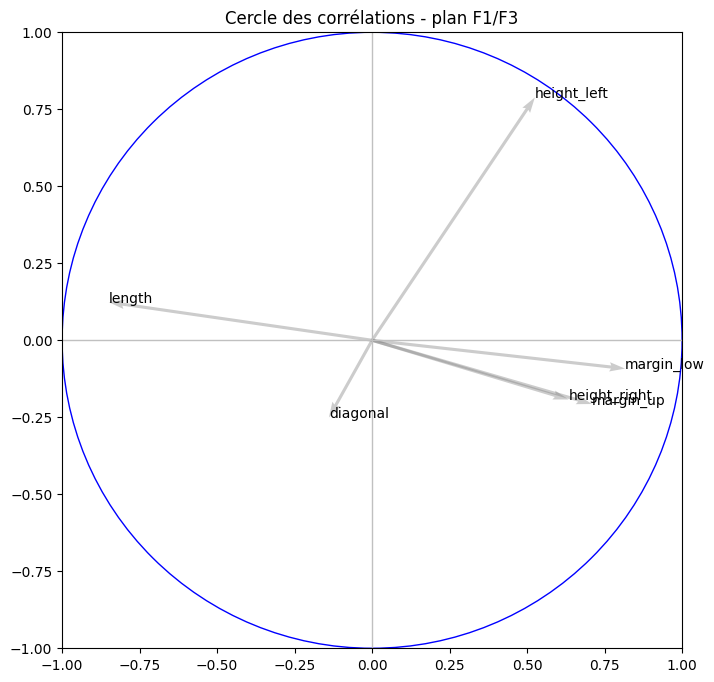

In [52]:
pca.correlation_circle_plot(1,3)

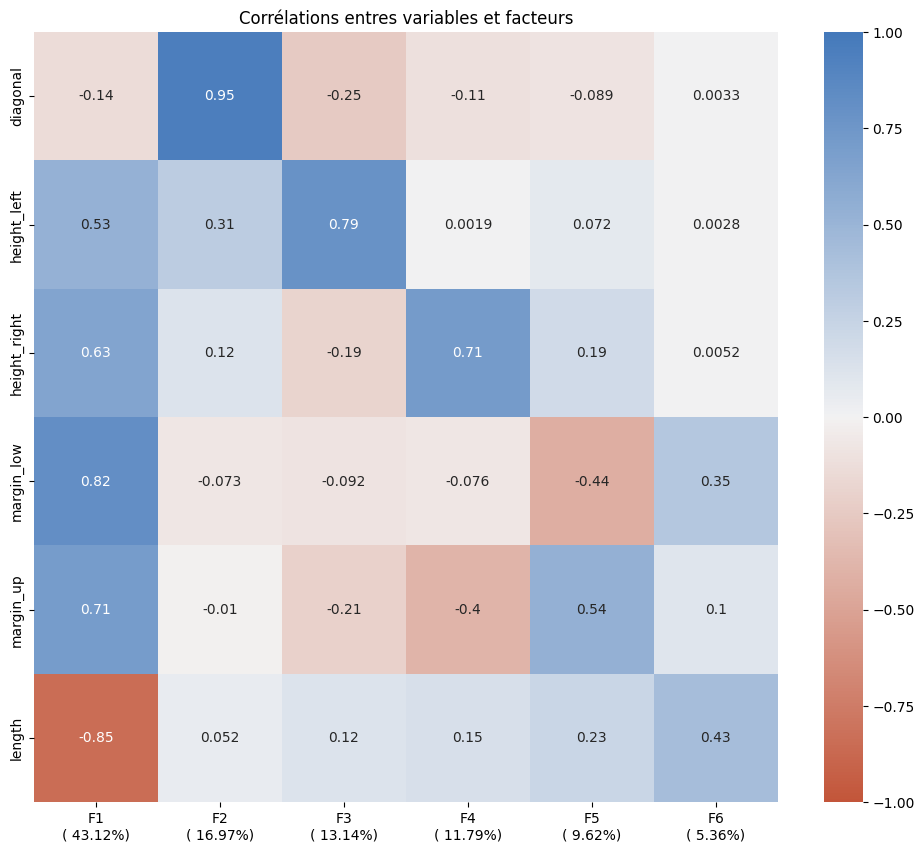

In [53]:
pca.correlation_variable_factor_plot()

In [54]:
# Récupération des X transformés par la PCA
X_transform_PCA = pca.X_transform

### 4.3 - Découpage jeu de données et scaling des données

In [55]:
# Découpage du jeu de données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"dimensions de X_train : {X_train.shape}")
print(f"dimensions de X_test : {X_test.shape}")

dimensions de X_train : (1024, 6)
dimensions de X_test : (439, 6)


In [56]:
type(X_train)

pandas.core.frame.DataFrame

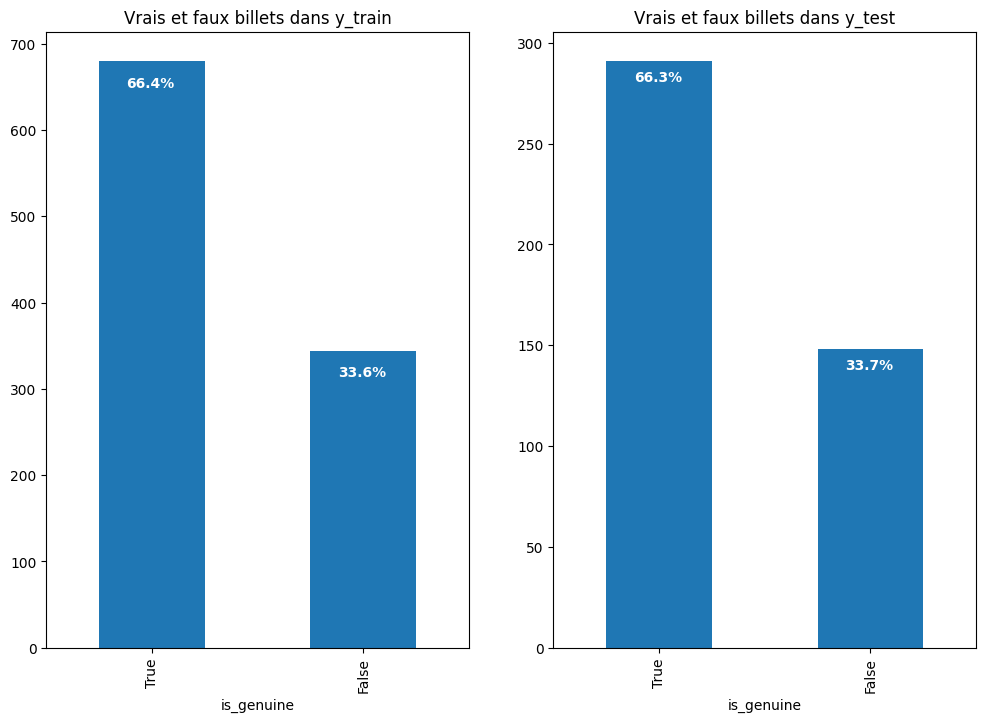

In [57]:
# Affichade de la répartition des vrais et faux billets dans y_train et y_test
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8))
# Y_trein
y_train.value_counts().plot.bar(ax=ax1)
# Ajouter les étiquettes de valeur
for p in ax1.patches:
    ax1.annotate(f"{p.get_height()/len(y_train):.1%}", (p.get_x()+0.13, p.get_height()-30), color="white", weight="bold")
ax1.set_title("Vrais et faux billets dans y_train")

y_test.value_counts().plot.bar(ax=ax2)
# Ajouter les étiquettes de valeur
for p in ax2.patches:
    ax2.annotate(f"{p.get_height()/len(y_test):.1%}", (p.get_x()+0.13, p.get_height()-10), color="white", weight="bold")
ax2.set_title("Vrais et faux billets dans y_test")
plt.show()

<div class="alert">
Les classes vrais et faux billets dans les données d'entrainement et de test semblent bien réparties.
</div>


In [58]:
# Scaling X pour Kmeans
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Scaling X_train & X_test
scaler_train_test = StandardScaler()
X_train_scaled = scaler_train_test.fit_transform(X_train)
X_test_scaled = scaler_train_test.transform(X_test)

### 4.4 - Kmeans

#### 4.4.1 - Détermination du nombre optimal de clusters

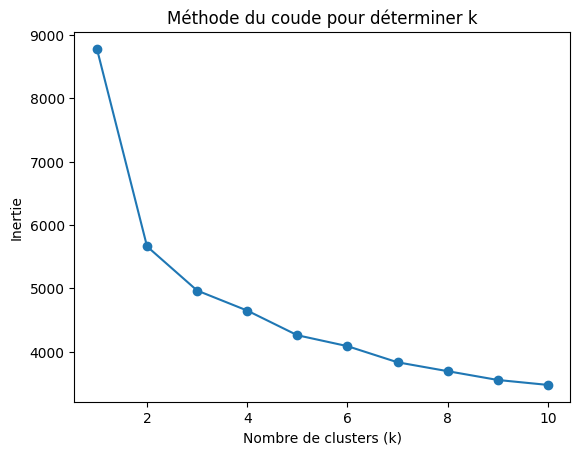

In [59]:
# Détermination du nombre de clusters optimal
inerties = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(X_scaled)
    inerties.append(kmeans.inertia_)

# Tracé de la courbe d'inertie
plt.plot(k_values, inerties, marker="o")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.title("Méthode du coude pour déterminer k")
plt.show()

<div class=alert-success>
La méthode du coude permet de déterminer le nombre optimal de clusters à utiliser pour le Kmeans.

Dans notre cas 2 clusters semblent être la valeur optimale ce qui correspond à 2 classes (peut-être vrais/faux)

#### 4.4.2 - Modèle Kmeans avec 2 clusters

In [60]:
# Instanciation de l'objet Kmeans avec 2 cluster (2 classes)
model_kmeans = KMeans(n_clusters=2,random_state=random_state)
model_kmeans.fit(X_scaled)

KMeans(n_clusters=2, random_state=101)

In [61]:
# Récupération des labels issus du clustering (différents clusters)
label_kmeans = model_kmeans.labels_

# Ajout des clusters aux données originales
df2 = df.copy() # Création d'une copie pour ne pas affecter les données originales
df2["cluster_kmeans"] = model_kmeans.labels_

# Récupération des centroïdes
centroid_kmeans_transform = pca.acp.transform(model_kmeans.cluster_centers_)

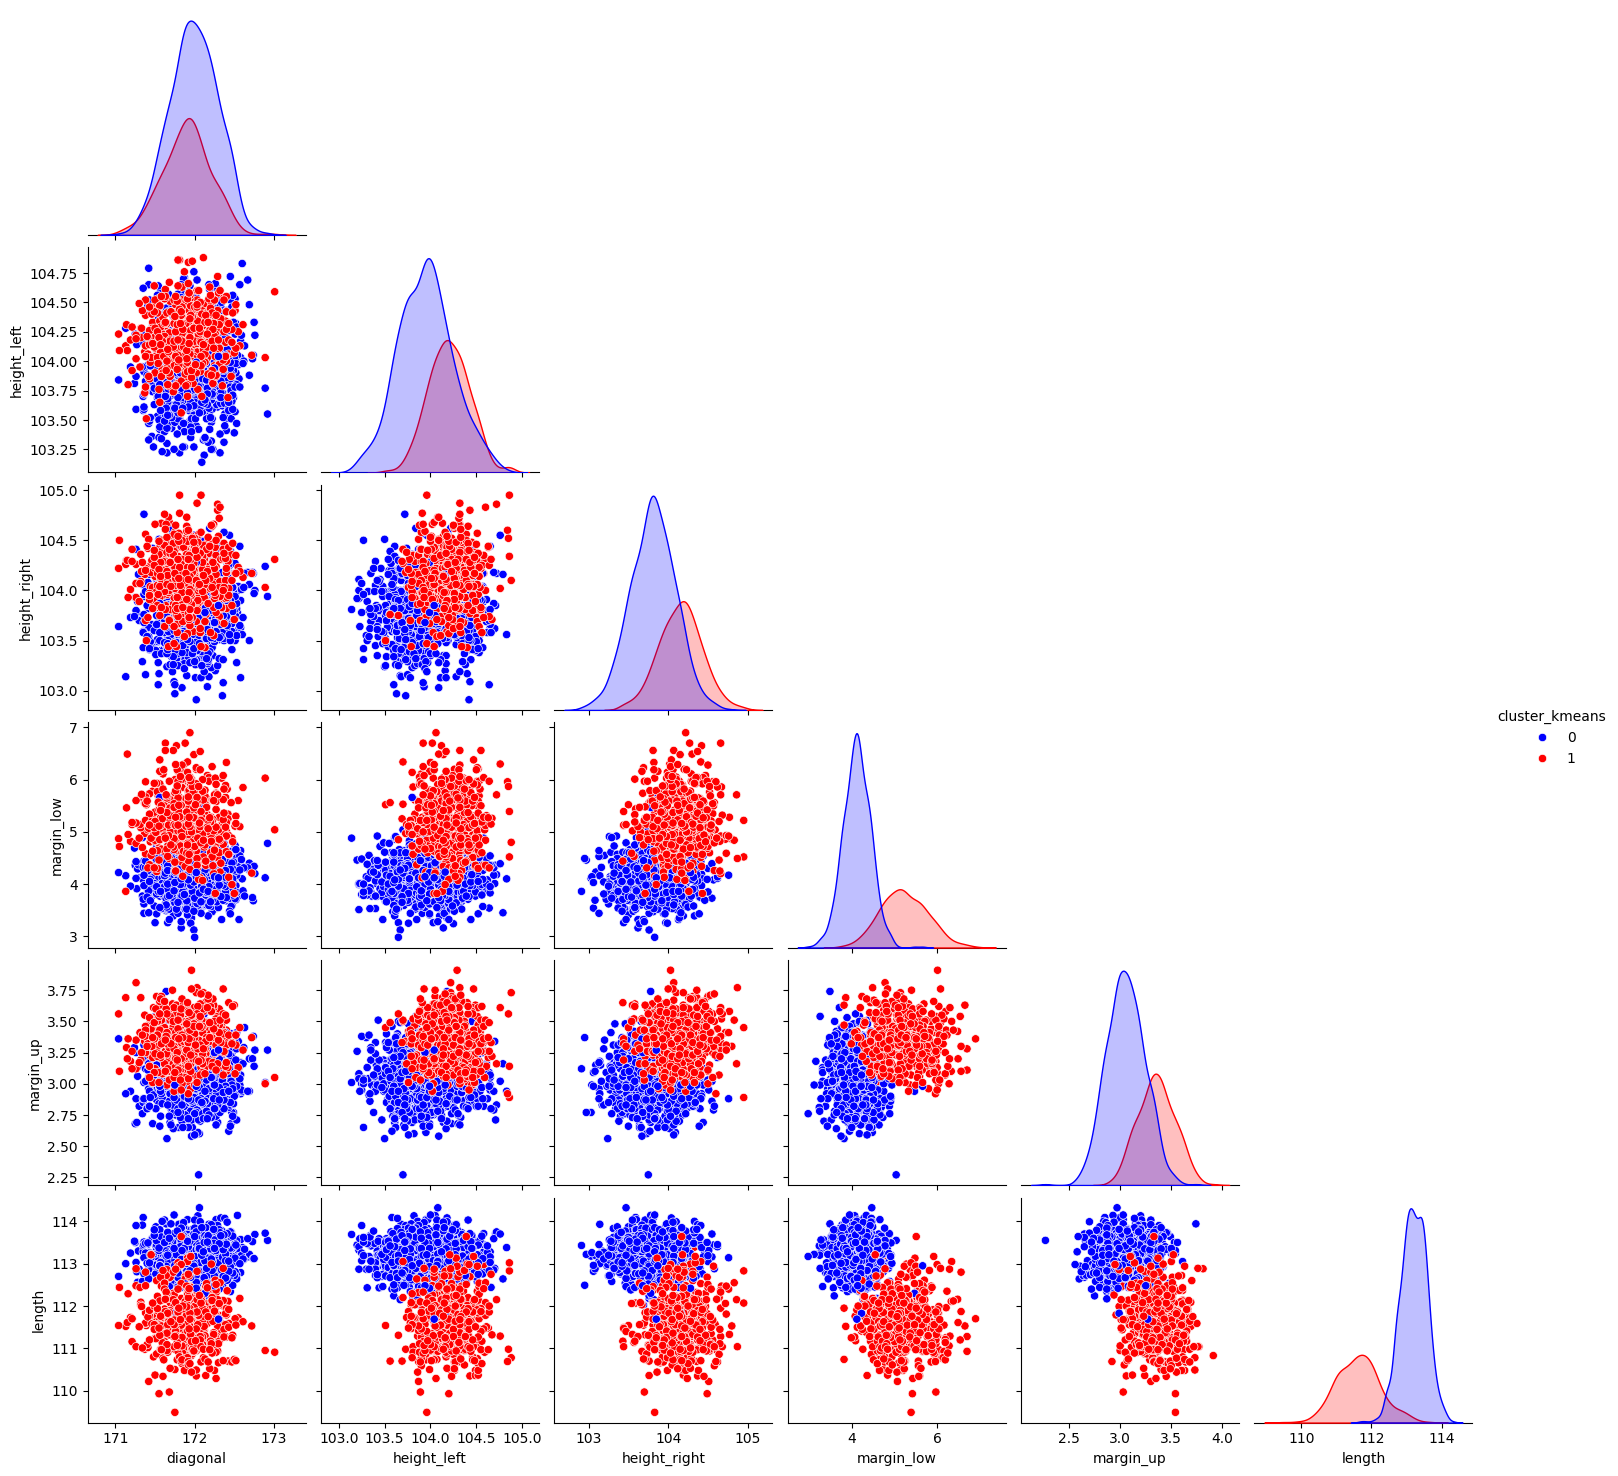

In [62]:
# Affichage des nuages de points entre chaque paire de variables en fonction des clusters
sns.pairplot(df2, vars=df2.select_dtypes(float).columns.values, hue="cluster_kmeans",
             palette = {0: 'blue', 1: 'red'},
             corner=True)
plt.show()

In [63]:
# Evaluation des performances du modèle Kmeans
inertie = model_kmeans.inertia_
print(f"Inertie : {inertie: .2f}")


silhouette_avg = silhouette_score(X_scaled, model_kmeans.labels_)
print(f"Score de silhouette : {silhouette_avg: .2f}")

Inertie :  5659.01
Score de silhouette :  0.34


<div class=alert-success>
L'algorithme Kmeans est une méthode d'apprentissage non supervisées. De fait, pour observer la performance des prédictions du modèle, les mesures utilisées sont différentes de celles utilisées par des méthodes d'apprentissage supervisé.

Pour le Kmeans, deux mesures peuvent être utilisées comme l'inertie et le score de silhouette.

Le score de silhouette étant plus facile à interpréter, cette métrics s'approche de -1 ou 1 si le modèle performe bien.


<div>

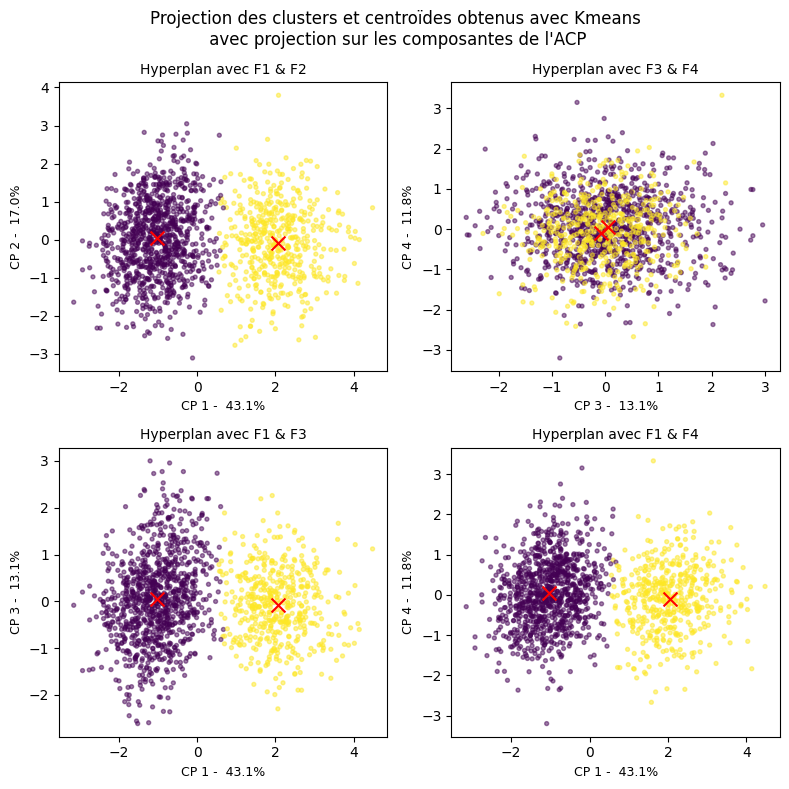

In [64]:
# Projetcion des données sur les 4 premieres composantes principales issues de l'ACP
hyperplans = [(1,2), (3,4), (1,3), (1,4)]
fig, ax = plt.subplots(2,2, figsize=(8,8))
plt.suptitle("Projection des clusters et centroïdes obtenus avec Kmeans\n avec projection sur les composantes de l'ACP")
for i, hyperplan in enumerate(hyperplans):
    ax_ = 0
    if i < 2:
        axe = ax[0,i]
    else :
        axe = ax[1,i%2]
        
    axe.scatter(X_transform_PCA[:, hyperplan[0]-1], X_transform_PCA[:, hyperplan[1]-1], c=model_kmeans.labels_, cmap="viridis", marker="o", s=8, alpha=0.5)
    axe.scatter(centroid_kmeans_transform[:, hyperplan[0]-1], centroid_kmeans_transform[:, hyperplan[1]-1], s=100, c="red", marker="x")
    axe.set_title(f"Hyperplan avec F{hyperplan[0]} & F{hyperplan[1]}", size=10)
    axe.set_xlabel(f"CP {hyperplan[0]} - {pca.acp.explained_variance_ratio_[hyperplan[0]-1]: .1%}", size=9)
    axe.set_ylabel(f"CP {hyperplan[1]} - {pca.acp.explained_variance_ratio_[hyperplan[1]-1]: .1%}", size=9)
plt.tight_layout()
plt.show()

##### Projection des clusters sur composantes de l'ACP

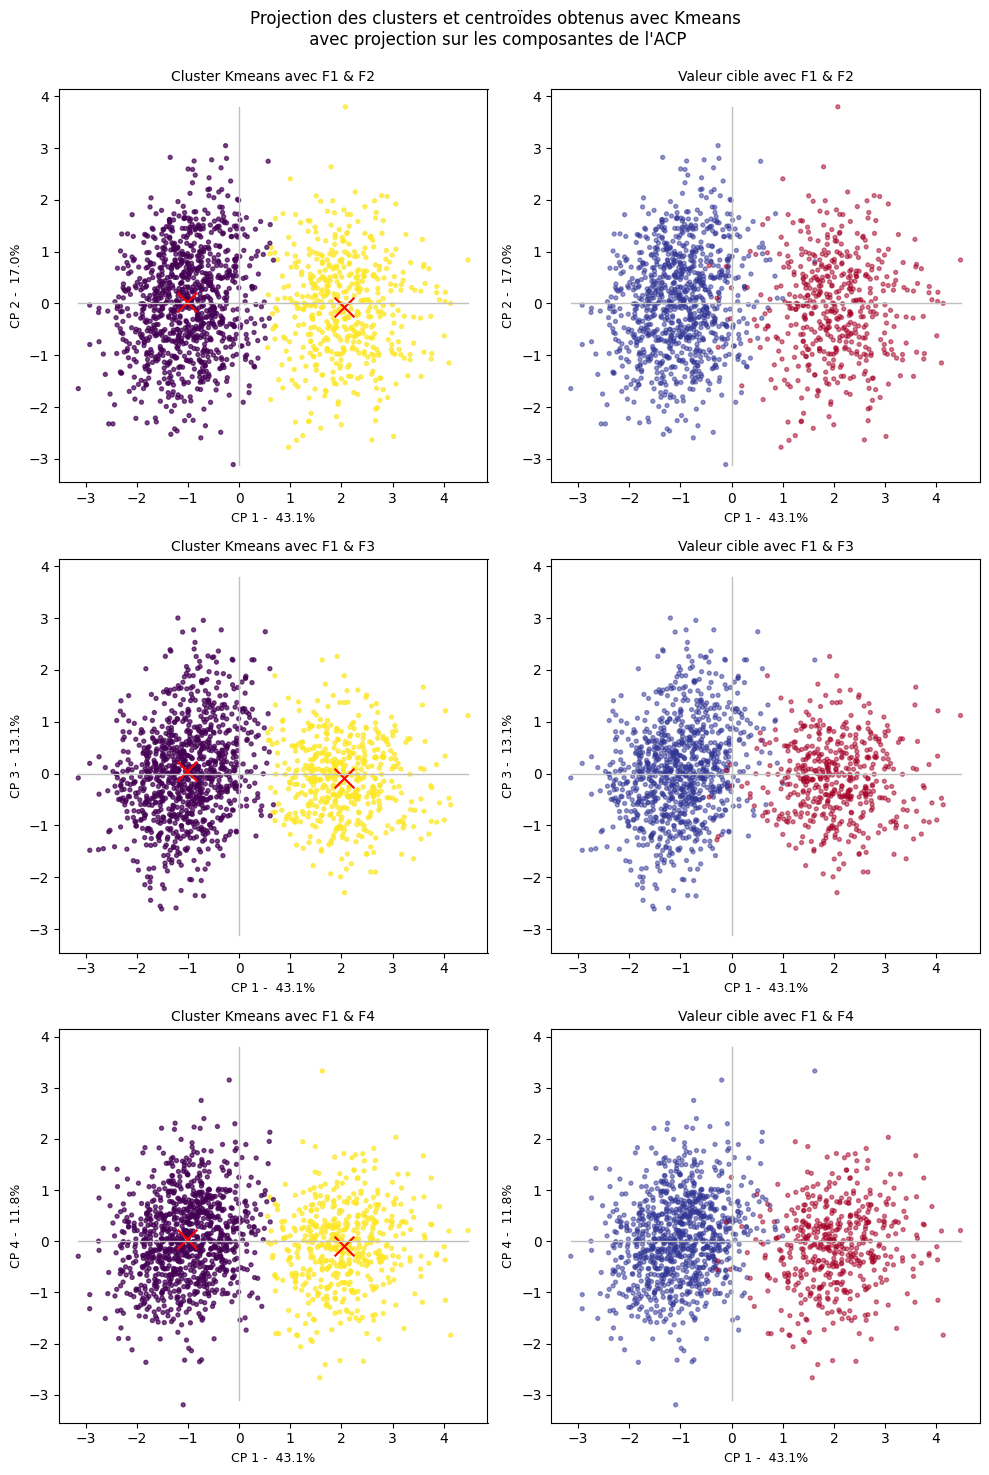

In [65]:
# Projection des points avec clusters Kmeans et valeurs cibles (vrai/faux) sur composantes principales de l'ACP
hyperplans = [(1,2), (1,3), (1,4)] # Hyperplans souhaités
fig, ax = plt.subplots(3,2, figsize=(10,15))
plt.suptitle("Projection des clusters et centroïdes obtenus avec Kmeans\n avec projection sur les composantes de l'ACP\n")
for i, hyperplan in enumerate(hyperplans):
    # Nuage de points avec clustering Kmeans 
    ax[i,0].scatter(X_transform_PCA[:, hyperplan[0]-1],
                    X_transform_PCA[:, hyperplan[1]-1],
                    c=model_kmeans.labels_, cmap="viridis",
                    marker="o", s=8, alpha=0.7)

    # Affichage des centroîdes
    ax[i,0].scatter(centroid_kmeans_transform[:, hyperplan[0]-1],
                    centroid_kmeans_transform[:, hyperplan[1]-1],
                    s=200, c="red", marker="x")
    ax[i,0].set_title(f"Cluster Kmeans avec F{hyperplan[0]} & F{hyperplan[1]}", size=10)
    ax[i,0].set_xlabel(f"CP {hyperplan[0]} - {pca.acp.explained_variance_ratio_[hyperplan[0]-1]: .1%}", size=9)
    ax[i,0].set_ylabel(f"CP {hyperplan[1]} - {pca.acp.explained_variance_ratio_[hyperplan[1]-1]: .1%}", size=9)

    # Nuage des points avec valeurs réelles vrai ou faux billets
    ax[i,1].scatter(X_transform_PCA[:, hyperplan[0]-1],
                    X_transform_PCA[:, hyperplan[1]-1],
                    c=y, cmap="RdYlBu", marker="o", s=8, alpha=0.5)
    ax[i,1].set_title(f"Valeur cible avec F{hyperplan[0]} & F{hyperplan[1]}", size=10)
    ax[i,1].set_xlabel(f"CP {hyperplan[0]} - {pca.acp.explained_variance_ratio_[hyperplan[0]-1]: .1%}", size=9)
    ax[i,1].set_ylabel(f"CP {hyperplan[1]} - {pca.acp.explained_variance_ratio_[hyperplan[1]-1]: .1%}", size=9)

    # Affiche les axes des composantes principales
    ax[i,0].plot([0, 0],(X_transform_PCA[:,1].min(),X_transform_PCA[:,1].max()),
                color='silver', linestyle='-', linewidth=1)
    ax[i,0].plot((X_transform_PCA[:,0].min(), X_transform_PCA[:,0].max()), [0, 0],
                color='silver', linestyle='-', linewidth=1)
    ax[i,1].plot([0, 0], (X_transform_PCA[:,1].min(), X_transform_PCA[:,1].max()),
                color='silver', linestyle='-', linewidth=1)
    ax[i,1].plot((X_transform_PCA[:,0].min(), X_transform_PCA[:,0].max()), [0, 0],
                color='silver', linestyle='-', linewidth=1)


plt.tight_layout()
plt.show()

In [66]:
# Moyenne par groupe
groupe_kmeans = df2.groupby("cluster_kmeans")
groupe_kmeans.size()

cluster_kmeans
0    976
1    487
dtype: int64

In [67]:
groupe_kmeans.mean()

is_genuine    diagonal  height_left  height_right  margin_low  \
cluster_kmeans                                                                  
0                 0.985656  171.988770   103.947469    103.806814    4.117756   
1                 0.018480  171.899918   104.199405    104.151273    5.223901   

                margin_up      length  
cluster_kmeans                         
0                3.053186  113.195973  
1                3.353285  111.630185

In [68]:
groupe_kmeans.describe().T

cluster_kmeans               0           1
diagonal     count  976.000000  487.000000
             mean   171.988770  171.899918
             std      0.301415    0.305189
             min    171.040000  171.040000
             25%    171.790000  171.695000
             50%    171.990000  171.910000
             75%    172.202500  172.090000
             max    172.920000  173.010000
height_left  count  976.000000  487.000000
             mean   103.947469  104.199405
             std      0.297380    0.224016
             min    103.140000  103.510000
             25%    103.740000  104.040000
             50%    103.950000  104.190000
             75%    104.140000  104.345000
             max    104.830000  104.880000
height_right count  976.000000  487.000000
             mean   103.806814  104.151273
             std      0.285578    0.270581
             min    102.910000  103.430000
             25%    103.610000  103.960000
             50%    103.810000  104.160000
             75%    103.992500  104.320000
             max    104.760000  104.950000
margin_low   count  976.000000  487.000000
             mean     4.117756    5.223901
             std      0.324205    0.544756
             min      2.980000    3.820000
             25%      3.907500    4.840000
             50%      4.115000    5.190000
             75%      4.340000    5.595000
             max      5.660000    6.900000
margin_up    count  976.000000  487.000000
             mean     3.053186    3.353285
             std      0.185550    0.178594
             min      2.270000    2.890000
             25%      2.930000    3.230000
             50%      3.050000    3.350000
             75%      3.180000    3.480000
             max      3.740000    3.910000
length       count  976.000000  487.000000
             mean   113.195973  111.630185
             std      0.366801    0.620454
             min    111.690000  109.490000
             25%    112.950000  111.190000
             50%    113.200000  111.620000
             75%    113.460000  112.030000
             max    114.320000  113.640000

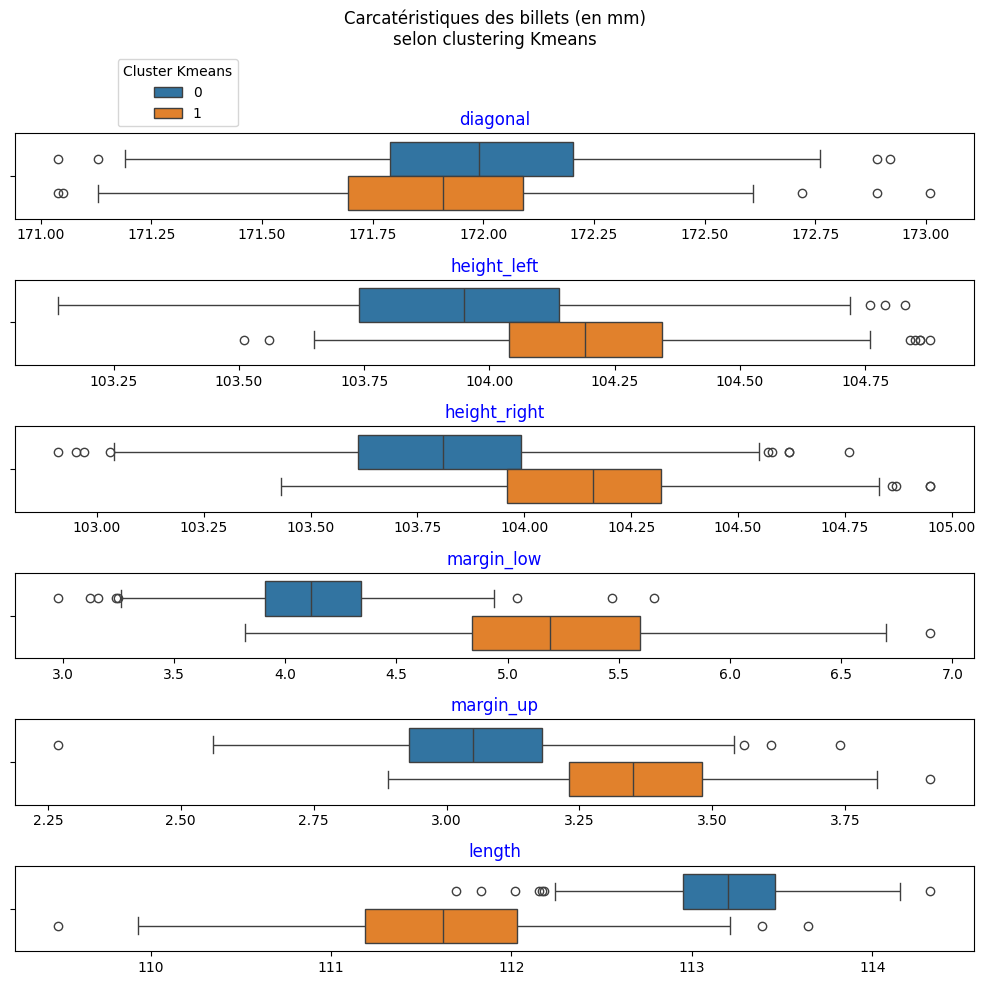

In [69]:
# Caractérisation des clusters issus du kmeans selon les variables géométriques des billets
filtered_cols = df2.select_dtypes(float).columns
fig, ax = plt.subplots(df2.shape[1]-2,1, figsize=(10,10))
plt.suptitle("Carcatéristiques des billets (en mm)\nselon clustering Kmeans")
for i, col in enumerate(df2.select_dtypes(float).columns):
    sns.boxplot(df2, x=col, hue="cluster_kmeans", ax=ax[i],
                 orient="h",
                 hue_order=[0, 1]
                 )
    # Ajout des moyennes avec pointplot
    ax[i].set_title(col, fontdict={'color': "Blue"})
    ax[i].set_xlabel(None)
        # Éviter la duplication de légendes
    if i == 0:
        ax[i].legend(title="Cluster Kmeans",
                    bbox_to_anchor=(0.1, 1)
                    )
    else:
        ax[i].legend_.remove()
plt.tight_layout()
plt.show()

<div class=alert-danger>
Comme vu dans les différents graphiques, la classification Kmeans ne performent pas bien.

Le score de silhouette et l'inertie confirme attestent d'un modèle K_means pas adapté à ce jeu de données

</div>

### 4.5 Régression logistique

La régression logistique est un algorithme de classification pour prédire des variables cibles catégorielles.

La régression logistique fonctionne en transformant une régression linèaire en un modèle de classification en utilsant la fonction logistique/sigmoïde.

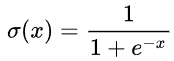

<div class = alert-success>
Interprétation des résultats :

- Metrics de classification :

    - Exactitude (Accuracy)

    - Précision (Precision)

    - Rappel (Recall)

- Courbes ROC

#### 4.5.1 Entrainement du modèle et prédictions

In [70]:
# Instanciation du modèle de régression linéaire
reg_log = linear_model.LogisticRegression(random_state=random_state,
                                          # verbose=1
                                          )

In [71]:
# help(linear_model.LogisticRegression)

In [72]:
# Paramètre pour le modele Logistic Regression
penalty = ["l1", "l2", "elasticnet"] # pénalité appliquée
l1_ratio = np.linspace(0, 1, 10) # ratio l1
C = np.logspace(0,10, 10) # Nombre de cross
solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'] # solver

param_grid = {
    "solver": solver,
    "penalty" : penalty,
    "l1_ratio" : l1_ratio,
    "C" : C}

In [73]:
# Entraînement du modèle
grid_model = GridSearchCV(reg_log, param_grid=param_grid, cv=5)
grid_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=101),
             param_grid={'C': array([1.00000000e+00, 1.29154967e+01, 1.66810054e+02, 2.15443469e+03,
       2.78255940e+04, 3.59381366e+05, 4.64158883e+06, 5.99484250e+07,
       7.74263683e+08, 1.00000000e+10]),
                         'l1_ratio': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']})

In [74]:
# Meilleurs parmètres avec la régression logistique
grid_model.best_params_

{'C': 1.0, 'l1_ratio': 0.0, 'penalty': 'l2', 'solver': 'liblinear'}

In [75]:
# Prédictions
y_pred = grid_model.predict(X_test_scaled)

In [76]:
# Réentrainement du modèle de Régression logistique avec les meilleurs paramètres

# Création d'une variabel avec les meilleurs paramètres
best_params = grid_model.best_params_
print(f"Meilleurs hyperparamètres :\n{best_params}")
# Instanciation avec les meilleurs hyperparamètres
model_reg_log_final = linear_model.LogisticRegression(C=best_params["C"],
                                                      l1_ratio=best_params["l1_ratio"],
                                                      penalty=best_params["penalty"],
                                                      solver=best_params["solver"],
                                                      random_state=random_state)

# Entrainement du modèle
model_reg_log_final.fit(X_train_scaled, y_train)

# Prédictions sur x_test
y_pred = model_reg_log_final.predict(X_test_scaled)

Meilleurs hyperparamètres :
{'C': 1.0, 'l1_ratio': 0.0, 'penalty': 'l2', 'solver': 'liblinear'}


#### 4.5.2 - Evaluation du modèle

In [77]:
# Accuracy du modele
print(f"accuracy : {accuracy_score(y_true=y_test, y_pred=y_pred)}")

# Matrice de confusion
print(f"confusion matrix : \n{confusion_matrix(y_true=y_test, y_pred=y_pred)}")

# Classification report
print(classification_report(y_true=y_test, y_pred=y_pred))

accuracy : 0.9977220956719818
confusion matrix : 
[[147   1]
 [  0 291]]
              precision    recall  f1-score   support

       False       1.00      0.99      1.00       148
        True       1.00      1.00      1.00       291

    accuracy                           1.00       439
   macro avg       1.00      1.00      1.00       439
weighted avg       1.00      1.00      1.00       439



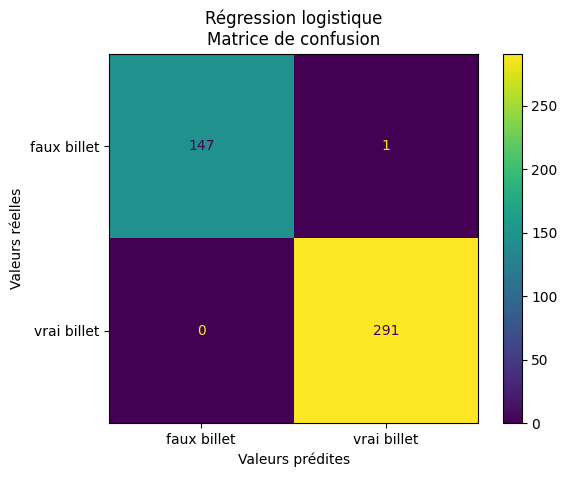

In [78]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, include_values=True,
                                        display_labels=["faux billet","vrai billet"],
                                        # normalize="all"
                                        )
plt.title("Régression logistique\nMatrice de confusion")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.show()

In [79]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

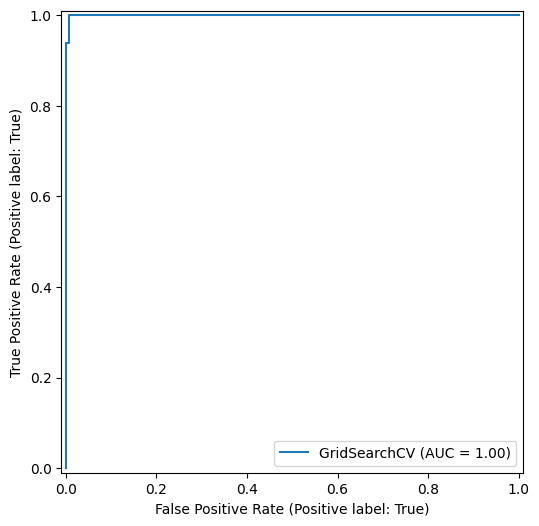

In [80]:
fig, ax = plt.subplots(figsize=(10,6))
RocCurveDisplay.from_estimator(grid_model, X_test_scaled, y_test, ax=ax)
plt.show()

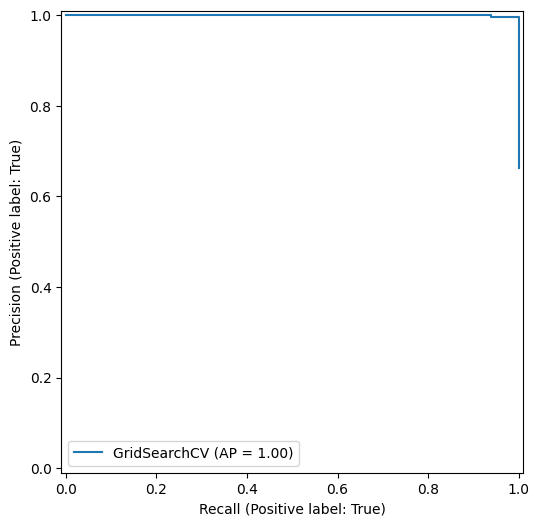

In [81]:
fig, ax = plt.subplots(figsize=(10,6))
PrecisionRecallDisplay.from_estimator(grid_model, X_test_scaled, y_test, ax=ax)
plt.show()

In [82]:
# Sauvegarde des scores des métriics
name_model = "Régression Logistique"
score_reg_log_final = save_score_test(model=model_reg_log_final, name_model=name_model, y_pred=y_pred, y_test=y_test)
score_reg_log_final

# Sauvegarde des prédictions

predictions_train_reg_log = model_reg_log_final.predict(X_train)
predictions_test_reg_log = y_pred


### 4.5 KNN

Attribue une etiquette aux nouvelles données en fonction de la distance aux étiquettes les plus proches

#### 4.5.1 - Choix du nombre de voisins méthode visuelle

In [83]:
# Entrainement du modèle et stockage de l'accuracy de train et de test

training_accuracy = []
test_accuracy = []
training_precision = []
test_precision = []


for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_scaled, y_train)
    # Accuracy
    train_acc = 1 - knn_model.score(X_train_scaled, y_train)
    training_accuracy.append(train_acc)
    test_acc = 1 - knn_model.score(X_test_scaled, y_test)
    test_accuracy.append(test_acc)

Text(0.5, 0, 'K-voisins')

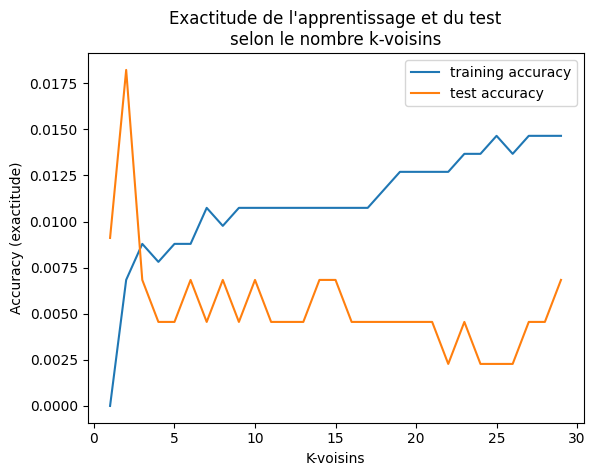

In [84]:
# Taux d'erreurs en fonction du nombre de voisins à considérer
plt.plot(range(1,30), training_accuracy, label="training accuracy")
plt.plot(range(1,30), test_accuracy, label="test accuracy")
plt.legend()
plt.title("Exactitude de l'apprentissage et du test\nselon le nombre k-voisins", size=12)
plt.ylabel("Accuracy (exactitude)")
plt.xlabel("K-voisins")

#### 4.5.2 - Choix du nombre de voisins avec GridSearchCV

In [85]:
# Dictionnaire de pramaètre pour la GridSearchCV
k_values = list(range(1,20))
param_grid = {"n_neighbors": k_values}

In [86]:
# Instanciation du modèle
model_knn = KNeighborsClassifier()

# Instanciation GridSearchCV
model_knn_grid_CV = GridSearchCV(model_knn,
                                 param_grid=param_grid,
                                 cv=5,
                                 scoring="accuracy")

# Entrainement du modèle
model_knn_grid_CV.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [87]:
# hyperparamètre du meilleu modèle
model_knn_grid_CV.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [88]:
# Prédictions avec le meilleur modèle 
y_pred = model_knn_grid_CV.predict(X_test)

              precision    recall  f1-score   support

       False       1.00      0.99      0.99       148
        True       0.99      1.00      1.00       291

    accuracy                           1.00       439
   macro avg       1.00      0.99      0.99       439
weighted avg       1.00      1.00      1.00       439

Accuracy : 0.9954
Precision : 0.9932
f1-score : 0.9966
ROC_AUC-score : 0.9932


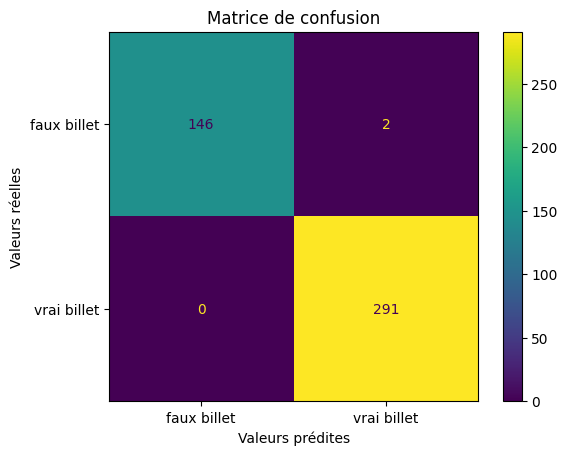

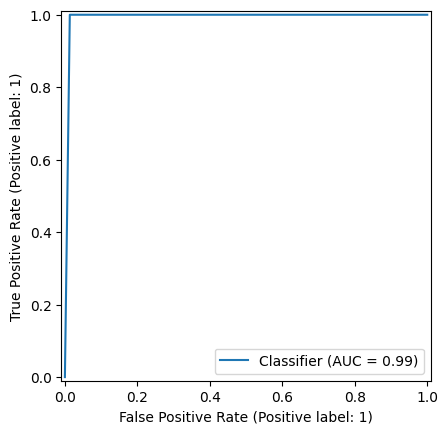

In [89]:
# Métrics du meilleur modèle
display_metrics_model(y_test, y_pred)

#### 4.5.3 - Entrainement modele knn optimal

<div class=alert-success>
<br>
Pour des performances plus optimales, le choix du nombre de voisins à retenir pour la construction de la classification avec l'algorithme KNN est le résultat de la GridSearchCV.

Afin de faciliter la comparaison de la performance des différents modèles, les scores et les prédictions sont sauvegardées.
<br>
<div>

In [90]:
# Récupération des hyperparamètres du meilleur modèle KNN
best_params_knn = model_knn_grid_CV.best_estimator_.get_params()

# Instanciation du KNN
model_knn_final = KNeighborsClassifier(n_neighbors=best_params_knn["n_neighbors"])
# Entrainement des données
model_knn_final.fit(X_train_scaled, y_train)

# Sauvegarde des prédictions

predictions_test_knn = model_knn_final.predict(X_test_scaled)
# predictions_train_knn = model_knn_final.predict(X_train_scaled)

# Sauvegarde des scores des métrics
name_model = "KNN"
score_knn_final = save_score_test(model = model_knn_final,
                                      name_model = name_model,
                                      y_test = y_test,
                                      y_pred = y_pred
                                      )
display(score_knn_final)


accuracy  precision  recall        f1   AUC_ROC  \
KNN  0.995444   0.993174     1.0  0.996575  0.993243   

                                        hyperparmeters  
KNN  {'algorithm': 'auto', 'leaf_size': 30, 'metric...

## 4.6 - Random Forest

<div class="alert-dark">
Hyperparamètres :

    - criterion = "gini" ou "entropy"
  
    - n_estimators = 100 par défaut

    - max_features = sqrt(N) recommandé / log2(N+1) / (N/3)

    - bootstrap = (True / False) extraction d'une sélection de lignes pour chaque division. Permet une meilleure généralisation du modèle

    - oob_score =      Out of Bag (echantillon des lignes non utilisées par le modèle). permet de vérifier la prédiction sur ces lignes. Attention différent des métrics globals. Cela n'affecte pas le traitement, et ne s'utilise qu"en cas de bootsraping. Elle ne peut être utilisé que pour les arbres de décision qui n'ont pas vu ces données. Par défaut à False
  
  (classification Y la plus votée) si bootstrap


Bootstrap et max_features permettent de ne voir à chaque entrainement d'un arbre de décision qu'une partie du dataset d'entrainement : certaines lignes et certaines features. Mais avec ces hyperparamètres le modèle n'utilisera jamais certaines lignes lié à l'échantillonnage
</div>


Pas de rique d'overfitting

<div class=alert-success>
<br>
L'algorithme de Random Forest se base sur les arbres de décision. Mais, il utilise une multitude de différents arbres construits avec tous ou partie des features et des lignes.

La prévision de classification est réalisée en retenant la classe majoritaire issue des résultats des différents arbres de décision.

L'algorithme Random Forest étant un modèle basé sur des arbres de décision, il n'est pas sensible à l'échelle des features. Donc, les données ne seront pas standardisées avant l'entrainement

<br>
</div>

In [91]:
# help(RandomForestClassifier)

#### 4.6.1 - Entrainement du modèle avec GridSearchCV

In [92]:
# instanciaton du modèle
rfc = RandomForestClassifier(random_state=random_state)

# Définition des hyperparamètres à tester
n_estimators = [64, 100, 128, 200] # Nombre d'arbre de décisions
max_features = [None, 2, 3, 4, 5] # ou ["sqrt", "log2", "None"] Nombre maximal de features utilisées par les arbres "individuels"
bootstrap = [True, False] # Bootstraping : echantillonne alétoirement des lignes pour et à chaque arbre de décision.

# Construction du dictionnaire d'hyperparamètres
param_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "bootstrap": bootstrap   
}

# Instanciation de la GridSearchCV
model_rfc_grid_CV = GridSearchCV(estimator=rfc,
                     param_grid=param_grid,
                     cv=5)

# Entrainement du modèle
model_rfc_grid_CV.fit(X_train, y_train)

print("Entrainement du modèle terminé")

Entrainement du modèle terminé


In [93]:
# Affichage des meilleurs hyperparamètres
model_rfc_grid_CV.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 2,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 101,
 'verbose': 0,
 'warm_start': False}

In [94]:
# Prédictions sur jeu de test
y_pred = model_rfc_grid_CV.predict(X_test)

              precision    recall  f1-score   support

       False       0.99      0.99      0.99       148
        True       0.99      0.99      0.99       291

    accuracy                           0.99       439
   macro avg       0.99      0.99      0.99       439
weighted avg       0.99      0.99      0.99       439

Accuracy : 0.9909
Precision : 0.9931
f1-score : 0.9931
ROC_AUC-score : 0.9898


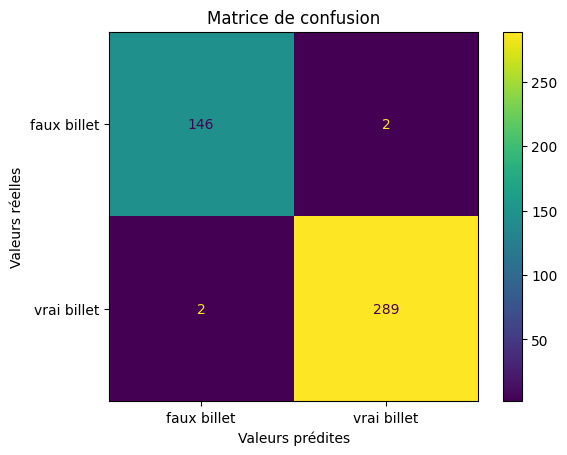

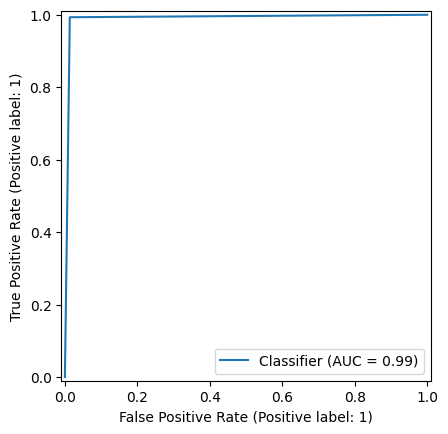

In [95]:
display_metrics_model(y_test, y_pred)

#### 4.6.2 - Choix du nombre d'arbres de décision optimal

In [96]:
# Contrôle de l'hyperparamètre n_estimators

accuracy = []
misclassifications = []
for n in range(1,128):
    rfc_test = RandomForestClassifier(max_features=2,
                                        n_estimators=n,
                                        bootstrap=True,
                                        random_state=random_state)
    rfc_test.fit(X_train, y_train)
    y_pred = rfc_test.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy.append(acc)
    n_missed = np.sum(y_pred != y_test)
    misclassifications.append(n_missed)

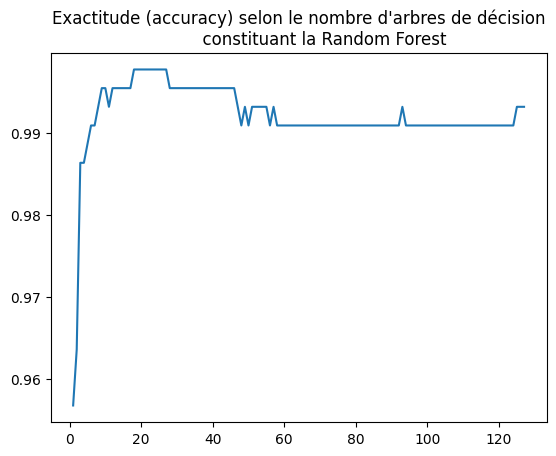

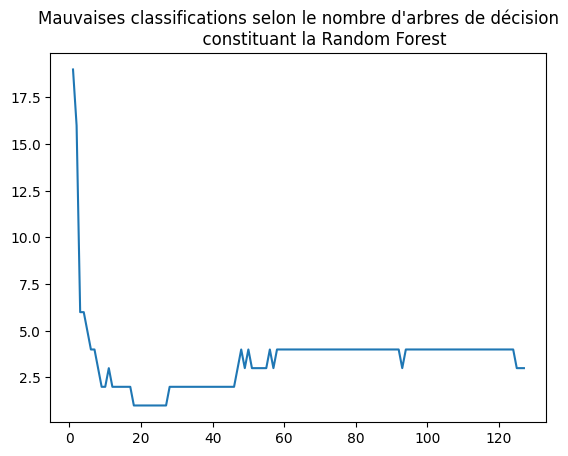

In [97]:
# Influence du nombre d'arbre de la RF sur l'exactitude et les erreurs

# Accuracy vs n_estimators
plt.plot(range(1,128), accuracy)
plt.title("Exactitude (accuracy) selon le nombre d'arbres de décision\n\
          constituant la Random Forest")
plt.show()


# Evolution du nombre de mauvaises classifications
plt.plot(range(1,128), misclassifications)
plt.title("Mauvaises classifications selon le nombre d'arbres de décision\n\
          constituant la Random Forest")
plt.show()

<div class=alert-success><br>
On observe que le résultat fournis dans la recherche croisée avec grille de paramètres pour la Random Forest est confirmé par les graphiques ci-dessus.

En effet, au dela de ce nombre les nouveaux arbres créés ne permettent plus l'amélioration du modèle<br>
.

</div>


#### 4.6.3 - Entrainement du modèle optimal

In [98]:
# Récupération des meilleurs paramètres
best_params = model_rfc_grid_CV.best_estimator_.get_params()
max_features = best_params["max_features"]
n_estimators=best_params["n_estimators"]
bootstrap=best_params["bootstrap"]

print("max_features :",max_features)
print("n_estimators :", n_estimators)
print("bootstrap :", bootstrap)

# Réentrainement du modèle avec les meilleurs paramètres
model_rfc_final = RandomForestClassifier(max_features=best_params["max_features"],
                                   n_estimators=best_params["n_estimators"],
                                   bootstrap=best_params["bootstrap"],
                                   random_state=random_state
                                   )

model_rfc_final.fit(X_train, y_train)

max_features : 2
n_estimators : 100
bootstrap : True


RandomForestClassifier(max_features=2, random_state=101)

In [99]:
type(X_test)

pandas.core.frame.DataFrame

In [100]:
# Sauvegarde des prédictions
predictions_train_rfc_log = model_reg_log_final.predict(X_train)
predictions_test_rfc_log = model_reg_log_final.predict(X_test)

# Sauvegarde des scores des métrics
name_model = "Random Forest"
score_reg_rfc_final = save_score_test(model=model_rfc_final, name_model=name_model, y_pred=y_pred, y_test=y_test)
score_reg_rfc_final

accuracy  precision    recall        f1   AUC_ROC  \
Random Forest  0.993166   0.993151  0.996564  0.994854  0.991525   

                                                  hyperparmeters  
Random Forest  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...

## 4.7 AdaBoost

<div class="alert alert-warning">
<b>Pas de suppression des outliers car elle risque d'entrainer de la perte d'information pour déterminer avec précision les faux billets.</b>
</div>

In [101]:
# help(AdaBoostClassifier())

#### 4.7.1 - Entrainement du modèle avec GridSearchCV

In [102]:
# Instanciation du modèle
adaboost = AdaBoostClassifier(algorithm="SAMME", random_state=random_state,)

# Hyparaamètres du modèles
n_estimators = [64, 100, 128, 200]
learning_rate = [0.01, 0.1, 0.5, 1, 1.5, 10]


param_grid = {
    "n_estimators":n_estimators,
    "learning_rate": learning_rate,
    # "max_features": max_features,
    # "bootstrap": bootstrap
    }

model_adaboost_grid_CV = GridSearchCV(adaboost,
                                      param_grid=param_grid,
                                      error_score='raise'
                                      )

model_adaboost_grid_CV.fit(X_train, y_train)

GridSearchCV(error_score='raise',
             estimator=AdaBoostClassifier(algorithm='SAMME', random_state=101),
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1, 1.5, 10],
                         'n_estimators': [64, 100, 128, 200]})

In [103]:
# Hyperparamètres du meilleur modèle
model_adaboost_grid_CV.best_estimator_.get_params()

{'algorithm': 'SAMME',
 'estimator': None,
 'learning_rate': 1.5,
 'n_estimators': 64,
 'random_state': 101}

In [104]:
# Prédictions
y_pred = model_adaboost_grid_CV.predict(X_test)


              precision    recall  f1-score   support

       False       0.99      0.99      0.99       148
        True       1.00      1.00      1.00       291

    accuracy                           1.00       439
   macro avg       0.99      0.99      0.99       439
weighted avg       1.00      1.00      1.00       439

Accuracy : 0.9954
Precision : 0.9966
f1-score : 0.9966
ROC_AUC-score : 0.9949


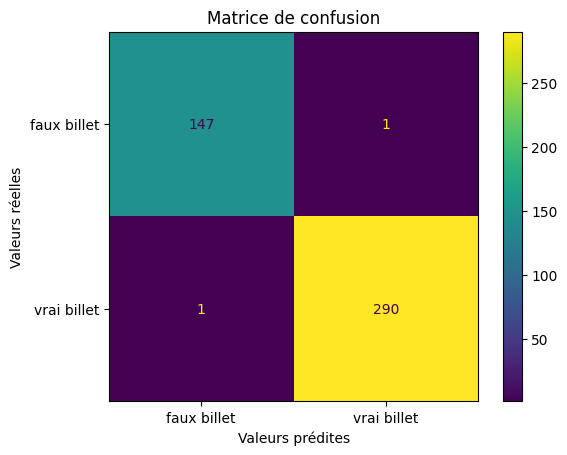

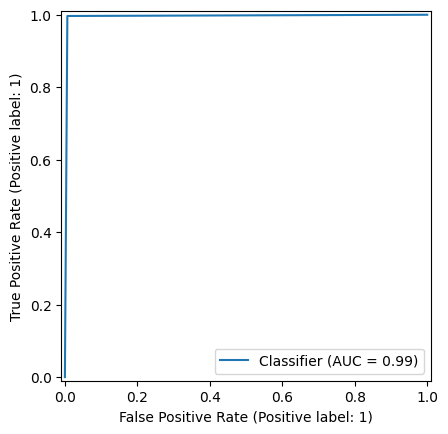

In [105]:
display_metrics_model(y_test, y_pred)

#### 4.7.2 - Entrainement du modèle optimal

In [106]:
# récupération des paramètres du meilleurs modèle
best_params = model_adaboost_grid_CV.best_estimator_.get_params()

In [107]:
# Construction du modèle optimal
model_adaboost_final = AdaBoostClassifier(algorithm=best_params["algorithm"],
                                          estimator=best_params["estimator"],
                                          learning_rate=best_params["learning_rate"],
                                          n_estimators=best_params["n_estimators"],
                                          random_state=random_state)

# Entrainement du modèle
model_adaboost_final.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME', learning_rate=1.5, n_estimators=64,
                   random_state=101)

In [108]:
# Sauvegarde des prédictions
predictions_train_adaboost = model_adaboost_final.predict(X_train)
predictions_test_adaboost = model_adaboost_final.predict(X_test)

# Sauvegarde des scores des métrics
name_model = "AdaBoost"
score_reg_adaboost_final = save_score_test(model=model_adaboost_final, name_model=name_model, y_pred=y_pred, y_test=y_test)
score_reg_adaboost_final

accuracy  precision    recall        f1   AUC_ROC  \
AdaBoost  0.995444   0.996564  0.996564  0.996564  0.994903   

                                             hyperparmeters  
AdaBoost  {'algorithm': 'SAMME', 'estimator': None, 'lea...

# 5. Comparaison des performances des modèles

### 5.1 Scores et visualisations des performances de classification

In [109]:
scores_models = pd.concat([score_reg_log_final, score_knn_final, score_reg_rfc_final, score_reg_adaboost_final])
scores_models

accuracy  precision    recall        f1   AUC_ROC  \
Régression Logistique  0.997722   0.996575  1.000000  0.998285  0.996622   
KNN                    0.995444   0.993174  1.000000  0.996575  0.993243   
Random Forest          0.993166   0.993151  0.996564  0.994854  0.991525   
AdaBoost               0.995444   0.996564  0.996564  0.996564  0.994903   

                                                          hyperparmeters  
Régression Logistique  {'C': 1.0, 'class_weight': None, 'dual': False...  
KNN                    {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
Random Forest          {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
AdaBoost               {'algorithm': 'SAMME', 'estimator': None, 'lea...

In [110]:
predictions_models = pd.DataFrame()

predictions_models["reg_log"] = predictions_test_reg_log
predictions_models["knn"] = predictions_test_knn 
predictions_models["rfc"] = predictions_test_rfc_log 
predictions_models["adaboost"] = predictions_test_adaboost 
# predictions_models["adaboost"] = predic 
predictions_models

reg_log    knn   rfc  adaboost
0      False  False  True     False
1       True   True  True      True
2       True   True  True      True
3       True   True  True      True
4       True   True  True      True
..       ...    ...   ...       ...
434     True   True  True      True
435    False  False  True     False
436     True   True  True      True
437     True   True  True      True
438     True   True  True      True

[439 rows x 4 columns]

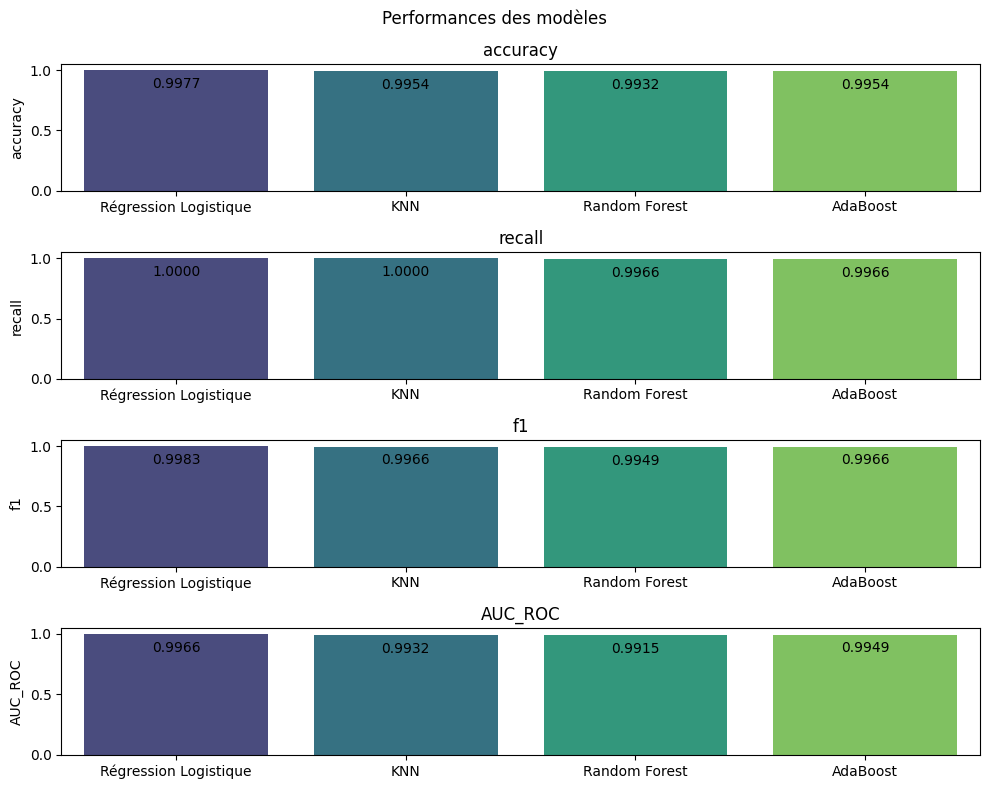

In [111]:
fig, ax = plt.subplots(4,1, figsize=(10,8))
plt.suptitle("Performances des modèles")
for i, col in enumerate(["accuracy",  "recall", "f1", "AUC_ROC"]):

    sns.barplot(scores_models[col], ax=ax[i], palette="viridis")
    ax[i].set_title(col)
    # Ajouter les étiquettes avec les valeurs
    for p in ax[i].patches:
        ax[i].annotate(format(p.get_height(), '.4f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, -10), textcoords = 'offset points')
plt.tight_layout()
    

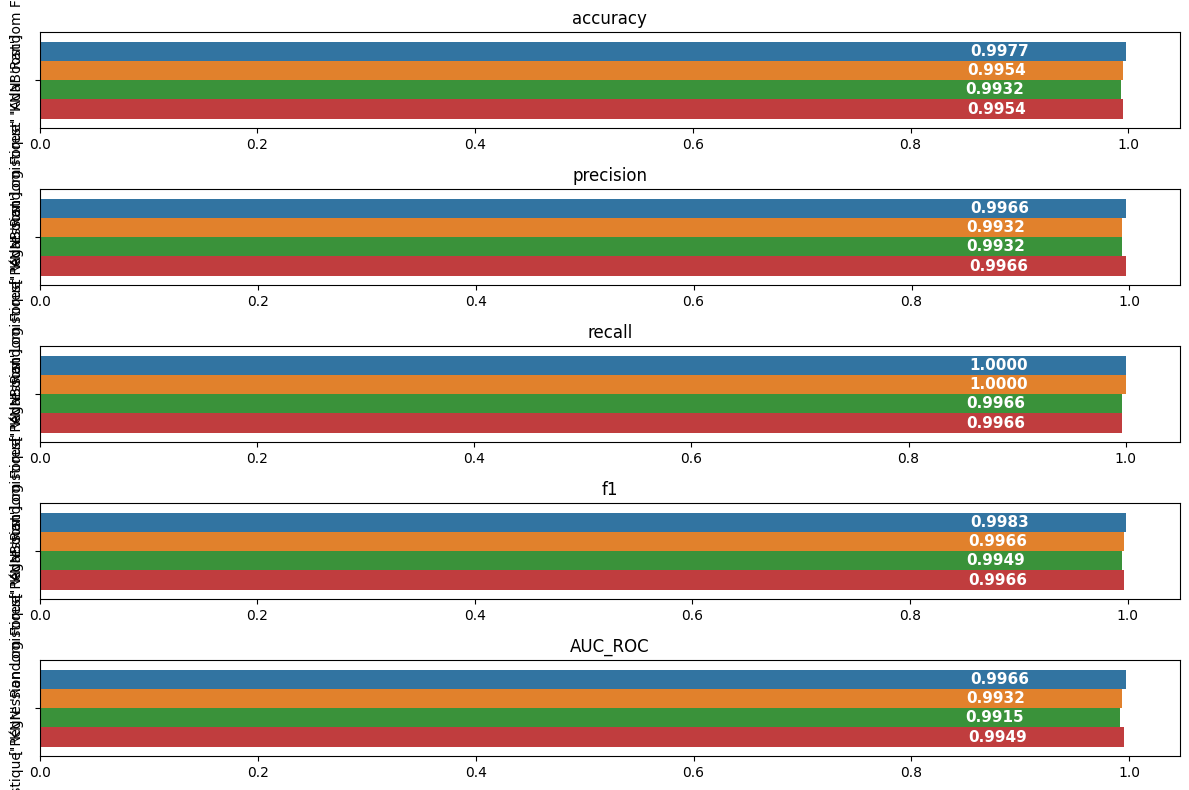

In [112]:
# Taille du Dataframe scores

df_temp = scores_models.drop("hyperparmeters",axis=1)

fig, ax = plt.subplots(5, 1, figsize=(12,8))

for i, col in enumerate(df_temp.columns):

    sns.barplot(x=df_temp[col], orient="h", hue=df_temp.index,ax=ax[i], legend=None)
    ax[i].set_title(col)
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(df_temp.index.values)
    

        # Ajouter les étiquettes avec les valeurs

    for p in ax[i].patches:
        ax[i].annotate(format(p.get_width(), '.4f'), 
                    (p.get_width()*0.85 , p.get_y() + p.get_height() / 2.),  # Position ajustée
                    ha='left', va='center', size=11, weight="bold", c="white",
                    xytext=(5, 0), textcoords='offset points')  # Décalage

plt.tight_layout()

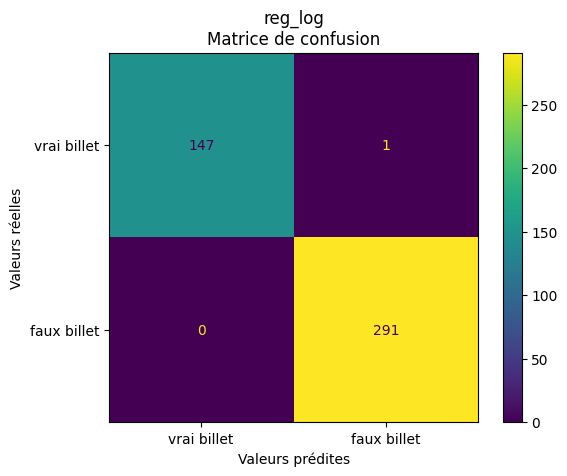

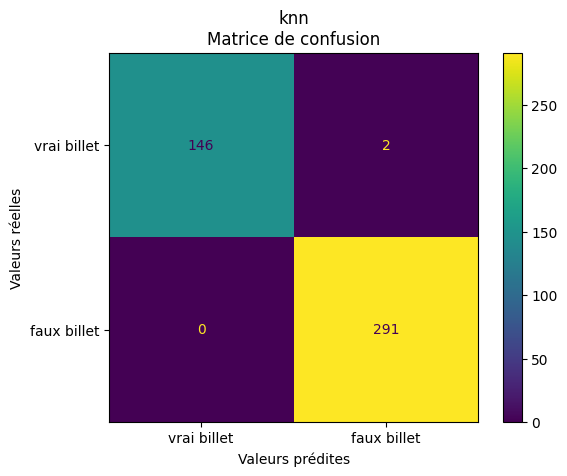

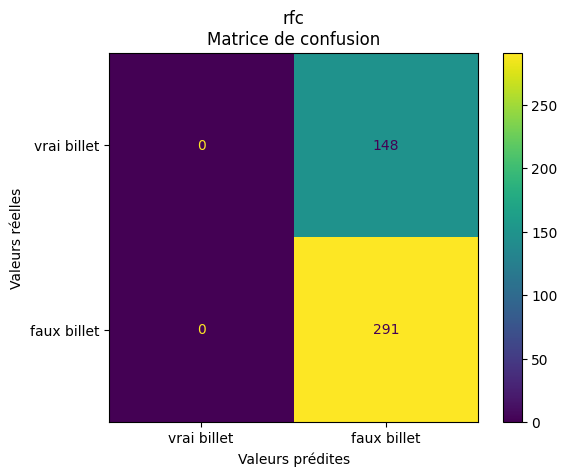

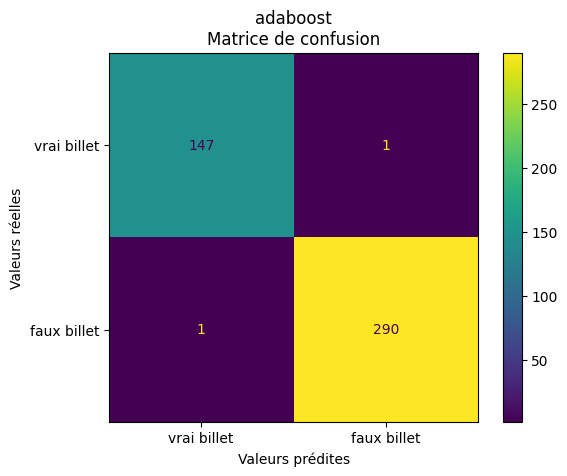

In [113]:
for col in predictions_models.columns:
    ConfusionMatrixDisplay.from_predictions(y_test, predictions_models[col],
                                            display_labels=["vrai billet", "faux billet"])
    plt.title(f"{col}\nMatrice de confusion")
    plt.xlabel("Valeurs prédites")
    plt.ylabel("Valeurs réelles")
    plt.show()


#### 5.2 Sauvegarde du meilleur modèle de classification

In [114]:
model_choice = model_reg_log_final

In [115]:
import pickle
# Sauvegarde du modele
with open('modele.pickle', 'wb') as fichier:
    pickle.dump(model_choice, fichier)

# Sauvegarde du scaler
with open('scaler.pickle', 'wb') as fichier:
    pickle.dump(scaler_train_test, fichier)

## 6 - Génération de fichier csv de test

In [116]:
# generate_sample_df(df)